# Machine Learning Project

In [ ]:
# Daniel Moskalchuk 293172
# Julia Tankiewicz 293719
# Nikita Bondarchuk 294478

The assignments below should be solved and documented as a project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises.
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to.

Please hand in assignment 1-6 in a _**single**_ Jupyter notebook where you retain the questions outlined below. You are welcome to adapt code from the web (e.g. Kaggle kernels), but you **_must_** reference the original source in your notebook. In addition to _clean, well-documented code_ (i.e. functions with <a href="https://www.geeksforgeeks.org/python-docstrings/">docstrings</a>, etc), your notebook will be judged according to how well each step is explained (using Markdown). 

In general, direct questions regarding assignments 1, 4, 5 and 6 to Frederik, and questions regarding assignments 2, 3, and 7 to Richard. 

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

**Groups:** Create your own groups. May be across teams. 2-4 students per group. No one-person groups.


**Submission deadline:** Thursday, December 15 before 13.00 CET (Notebooks + presentation recording)

**Expected workload:** Each student is expected to spend around around 50 hours on the project.

### Deliverables
The teams have to submit three deliverables before the submission deadline: 1) a notebook of assignments 1-6, 2) a notebook of assignment 7, and 3) presentation video uploaded to some online platform e.g. YouTube, Vimeo, etc.

#### Notebook
The notebook contains all the code to explore the dataset, train the final model and documents each step clearly. If code is copied from another codebase such as Github or Stack Overflow it **_must_** be properly referenced.


#### Presentation
The presentation video should be 15 min long and should highlight the problem you are solving, interesting things you found in the data and the step involved in building up your model. At the exam we will discuss the presentation and ask questions about your project and submissions. A link to the video must be placed in the notebook for assignment 7.

### Randomness
For ALL random states, choose state = 69 so we can replicate your work.


In [2]:
# Import all necessary modules here:
#To use following packages, pip install them first 
#pip install opencv-python
#pip install keras
#pip install --no-cache-dir tensorflow
#pip install shapely
#pip install geopandas
#pip install graphviz
#pip install pydotplus

from pathlib import Path
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
import pydotplus

from sklearn import (decomposition, ensemble, metrics)


#from sklearn import (neighbors, datasets, decomposition, ensemble,metrics, model_selection, preprocessing, linear_model)
#from keras.preprocessing import image
#from tensorflow.keras.utils import load_img, img_to_array


## 1. The IceCat Dataset

__You should be able to do this exercise after Lecture 3.__

The IceCat Dataset, kindly provided to us by Stibo Systems, contains a large amount of data on different office products. As an example of "real-world" data, these data are imperfect and incomplete. As such, this exercise is not so much an exercise in creating a good machine learning model, but places a larger emphasis on "cleaning the data".

We are going to work with a subset of the IceCat Dataset. In particular, you will be provided with a zip file of 5,854 images of office products, each with the name "product ID".jpg. You will also be provided with a list of colors, `colors.txt`, which, when imported using the code below, is a list of tuples of the form `[("product ID", "color"), ...]`. (The code below assumes that `colors.txt` is in the same folder as the jupyter notebook. Feel free to change the code if you prefer a different organization of your files).

Your task is to clean up the data and construct a simple machine learning model (_e.g._, _k_-nearest neighbor) that can identify the color of a product. You have free hands - there is hardly any one "correct answer" - but you need to argue for your choices. Among other things, you probably need to think about the following as you work with the data:

* All of the images have different sizes.

* Some of the images are RGB images (3 layers), others are CMYK (4 layers), some might even be black-and-white (1 layer).

* Some colors are only represented by very few products.

* Some colors are very similar, such as "Purple" and "Violet".

* A product may have a particular color, but a packaging of a different color. Similarly, the color of, say, a computer monitor may be black, while the image of it could show a monitor that is turned on with a green screensaver.

* Many products are attributed to several colors, such as "Black, Blue" or even "Blue, Green, Orange, Violet, Yellow". Yet others are described as "Multicolor" or "Assorted colors".

Again, you have free hands in how you are going to solve these (and other) challenges, but you must argue for and reflect on your choices as you progress.


In [15]:
color_mappings = {
  # source color => arr of colors associated with the source color
    'Grey' : ['Silver', 'Metallic', 'Aluminium', 'Stainless steel', 'Platinum', 'Graphite', 'Chrome', 'Anthracite','Light Grey','Charcoal','Titanium','Light grey'],
    'Purple' : ['Violet', 'Lavender', 'Fuchsia','Magenta'],
    'Transparent' : ['Translucent'],
    'Cream' : ['Beige', 'Sand', 'Tan','Cappuccino','Ivory'],
    'Brown' : ['Oak colour', 'Wood','Bronze'],
    'Cyan' : ['Turquoise', 'Aqua colour'],
    'White' : ['Pearl' ],
    'Pink' : ['Rose'],
    'Red' : ['Cherry', 'Bordeaux'],
    'Green' : ['Pine', 'Lime','Olive'],
    'Yellow' : ['Gold'],
    'Blue' : ['Navy'],
    'Multicolour' : ['Multi','Assorted colours']
}

inputDataMock = {
    'img_id': [],
    'red1': [], 'green1': [], 'blue1': [],
    'red2': [], 'green2': [], 'blue2': [],
    'red3': [], 'green3': [], 'blue3': [],
    'red4': [], 'green4': [], 'blue4': [],
    'red5': [], 'green5': [], 'blue5': [],
    'color': []
}

___---METHODS---___

In [16]:
# returns the source color in response to the associated color using the color_mappings
def colors_binning(initial_color):
    for source_color in color_mappings:
        if initial_color in color_mappings[source_color]: return source_color;
    return initial_color;

In [17]:
# returns a dataframe from colors.txt
def getCorrectAnswersDF():
    with open("datasets/1/colors.txt","r") as file:
        colors = ast.literal_eval(file.read())
        # lets create a dataframe
        d = {'pic_id': [], 'color': []}
        for row in colors:
            # check if there are more colors in one row
            colors_arr = row[1].split(", ")
            d['pic_id'].append(row[0])
            d['color'].append(colors_binning(colors_arr[0])) 

        pic_colors = pd.DataFrame(data=d)
        return pic_colors;

In [18]:
def getImgDataSorted(imgData, ignoreWhite = True, colorRound = 2, whiteThreshold = 0.15):
    pixel_arr = {}
    white = 1 - whiteThreshold;
    # itearate over images rows
    for imgRow in imgData:
        # iterate over pixels
        for pixelData in imgRow:
            red = round(pixelData.item(0) / 255, colorRound)
            green = round(pixelData.item(1) / 255, colorRound)
            blue = round(pixelData.item(2) / 255, colorRound)
            
            # skip white pixels
            if (ignoreWhite and red >= white and green >= white and blue >= white): 
                continue;
                
            key = str(red) +' '+ str(green) +' '+ str(blue);
            # if this pixel color is found in pixel_arr
            if (pixel_arr.get(key)): 
                pixel_arr[key]['count'] += 1 # add 1 to the counter
            else: # insert the color, set the counter to 1
                pixel_arr[key] = {'R': red, 'G': green, 'B': blue, 'count': 1};
    # sort the pixels by number of occurencies and return
    return sorted(pixel_arr.values(), key=lambda x: x['count'], reverse=True)

def PopulateData(pic_id, pixel_arr, correctAnswer):      
    # move the data to the dataFrame mock
    inputDataMock['img_id'].append(pic_id)
    
    for i in range(1,6):
        try:
            color = pixel_arr[i-1]
        except IndexError: # Index out of range - no more colors found
            color = {'R': 1.0, 'G': 1.0, 'B': 1.0}
            
        inputDataMock['red'+str(i)].append(color['R'])
        inputDataMock['green'+str(i)].append(color['G'])
        inputDataMock['blue'+str(i)].append(color['B'])
    
    for row_id, row in correctAnswer.iterrows():
        col = str(row['color']).strip()
        if len(col) == 0: col = None;
        
        inputDataMock['color'].append(col)
        break;

In [19]:
def testAccuracy(X_train, y_train, X_test, y_test):#lets see how accuracy depends on number of neighbours
    #training_accuracy = []
    #test_accuracy = []
    diff_arr = []
    # try n_neighbors from 1 to 10
    neighbors_settings = range(3, 25)

    for n_neighbors in neighbors_settings:
        # build the model
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        clf.fit(X_train, y_train)
        # record training set accuracy
        train = clf.score(X_train, y_train)
        test = clf.score(X_test, y_test)
        diff = (train - test) / ((train + test) * 0.5)
        #training_accuracy.append(train)
        # record generalization accuracy
        #test_accuracy.append(test)
        diff_arr.append(diff)

    #plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
    #plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
    plt.plot(neighbors_settings, diff_arr, label="diff")
    plt.ylabel("Accuracy")
    plt.xlabel("n_neighbors")
    plt.legend(); 

In [26]:
def resize_img(img, dimension=(64, 64)):
    img_resized = cv.resize(img, dimension, interpolation=cv.INTER_AREA)
    return img_resized

def normalize_img(img):
    if img.shape == (64, 64):
        img = cv.cvtColor(img.astype('float32'),cv.COLOR_GRAY2RGB)
    elif img.shape == (64, 64, 4):
        img = cv.cvtColor(img.astype('float32'),cv.COLOR_RGBA2RGB)

    return img

def compress_img(img, nr_of_colors = 16):
    
    # Lets compress the image using clustering
    # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv.KMEANS_PP_CENTERS
    compactness, labels, centers = cv.kmeans(np.float32(img.reshape((-1, 3))),
                                    nr_of_colors, None, criteria, 10, flags)
    centers = np.uint8(centers)
    new_colors = centers[labels.flatten()]
    img_noramlized = new_colors.reshape(img.shape)
    return img_noramlized
    

In [27]:
# MAIN
def main(container_path, neigbours = 18, limit = 0):
    image_dir = Path(container_path)
    count = 0
    img_hash = {}
    uniq_img = []
    
    # first of all - correct answers
    correct_answers_DF = getCorrectAnswersDF();
    
    for file in image_dir.iterdir():

        img = plt.imread(file)
        
        img_resized = resize_img(img)
        
        count+=1;
        if limit > 0 and count > limit: break;
        
        img_arr = img_resized.tolist()
        if img_arr in uniq_img: continue;
        
        pic_id = file.stem
        
        uniq_img.append(img_arr)
        
        img_normalized = normalize_img(img_resized)
        
        img_compressed = compress_img(img_normalized)
        
        img_pixels_colors = getImgDataSorted(img_compressed)

        right_answerDF = correct_answers_DF[correct_answers_DF['pic_id'] == int(pic_id)]
        
        PopulateData(pic_id, img_pixels_colors, right_answerDF)
        
        #plt.title(file.stem)
        #plt.imshow(img_normalized)  
    
    inputData = pd.DataFrame(data=inputDataMock)
    
    inputData = inputData.drop(columns = ['red4', 'green4', 'blue4', 'red5', 'green5', 'blue5']) #
    
    #inputData = pd.unique(inputData)
    
    color_counts = inputData['color'].value_counts(ascending=True)

    for color, count in color_counts.items():
        if(count < 2): inputData.drop(inputData[inputData['color'] == color ].index, inplace=True)
        else: break; 
        
    display(inputData)
    
    X = inputData.drop(columns = ['img_id', 'color'])
    Y = inputData['color']
    
    # split the data in training and test set
    X_train, X_test, y_train, y_test = train_test_split(
    X, Y, stratify=Y, random_state=69)
    
    knn = KNeighborsClassifier(n_neighbors=neigbours)
    knn.fit(X_train, y_train)
    print("Train set score of "+str(neigbours)+"-nn: {:.2f}".format(knn.score(X_train, y_train)))
    print("Test set score of "+str(neigbours)+"-nn: {:.2f}".format(knn.score(X_test, y_test)))
    
    #testAccuracy(X_train, y_train, X_test, y_test)
            
main("datasets/1/images");

,img_id,red1,green1,blue1,red2,green2,blue2,red3,green3,blue3,color
0,10646476,0.25,0.25,0.26,0.87,0.85,0.84,0.78,0.76,0.75,Multicolour
1,10657867,0.67,0.67,0.67,0.73,0.74,0.73,0.02,0.01,0.01,Black
2,10672976,0.82,0.82,0.82,0.78,0.78,0.79,0.72,0.72,0.72,White
3,10689258,0.14,0.14,0.14,0.20,0.20,0.20,0.96,0.43,0.22,Black
4,10717657,0.78,0.78,0.78,0.84,0.84,0.84,0.80,0.80,0.81,White
...,...,...,...,...,...,...,...,...,...,...,...
5124,9728477,0.11,0.20,0.29,0.04,0.14,0.23,0.15,0.24,0.33,Blue
5125,9752270,0.82,0.82,0.82,0.76,0.76,0.76,0.07,0.07,0.07,Black
5126,9752649,0.84,0.84,0.89,0.81,0.81,0.87,0.68,0.69,0.80,Multicolour
5127,9935992,0.80,0.80,0.78,0.73,0.73,0.72,0.77,0.76,0.76,White


Train set score of 18-nn: 0.60
Test set score of 18-nn: 0.54


## 2. Flights Departing from NYC

__You should be able to do this exercise after Lecture 4.__

For this exercise we will be using the famous nycflights13 data which contains the `airlines`, `airports`, `flights`, `planes`, and `weather` datasets. Please see the documentation (`nycflights13.pdf`) for further information.

**(a)** Load all files as pandas dataframes and display the first 5 rows of each dataset.

In [28]:
#JULIA
#loading
airlines = pd.read_csv('datasets/2/airlines.csv')
airports = pd.read_csv('datasets/2/airports.csv')
flights = pd.read_csv('datasets/2/flights.csv')
planes = pd.read_csv('datasets/2/planes.csv')
weather = pd.read_csv('datasets/2/weather.csv')
#displaying
display(airlines.head())
display(airports.head())
display(flights.head())
display(planes.head())
display(weather.head())

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.


,faa,name,lat,lon,alt,tz,dst,tzone
0,04G,Lansdowne Airport,41.130472,-80.619583,1044,-5.0,A,America/New_York
1,06A,Moton Field Municipal Airport,32.460572,-85.680028,264,-6.0,A,America/Chicago
2,06C,Schaumburg Regional,41.989341,-88.101243,801,-6.0,A,America/Chicago
3,06N,Randall Airport,41.431912,-74.391561,523,-5.0,A,America/New_York
4,09J,Jekyll Island Airport,31.074472,-81.427778,11,-5.0,A,America/New_York


,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
3,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0
4,2013,1,1,554.0,-4.0,740.0,12.0,UA,N39463,1696,EWR,ORD,150.0,719,5.0,54.0


,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan
1,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
2,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
3,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
4,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z


**(b)** Convert all temperature attributes to degree Celsius. We will be using this in what follows.

In [29]:
#JULIA
weather['temp'] = (weather['temp']-32)*5/9
weather['temp']

0        2.8
1        2.8
2        3.3
3        3.3
4        3.3
        ... 
26125    2.2
26126    1.1
26127    0.0
26128   -0.6
26129   -1.7
Name: temp, Length: 26130, dtype: float64

**(c)** Using OLS, investigate if flight distance is associated with arrival delay. You should be cautious regarding negative delays.

R^2 on train data is 0.0005788038321236089 and on test data is 0.00024372663477112422
The coefficents are [-0.00131288] and the intercept is 3.893709244732308
           arr_delay  distance
arr_delay    1.00000  -0.02094
distance    -0.02094   1.00000


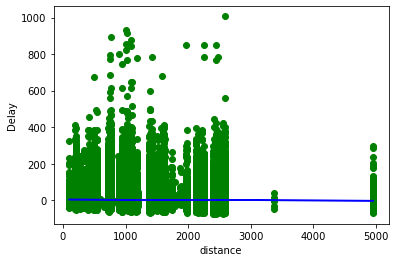

R^2 on train data is 2.2108193384440256e-05 and on test data is -4.7688311769711333e-05
The coefficents are [0.00031661] and the intercept is 35.98106341556762
           arr_delay  distance
arr_delay   1.000000  0.001957
distance    0.001957  1.000000


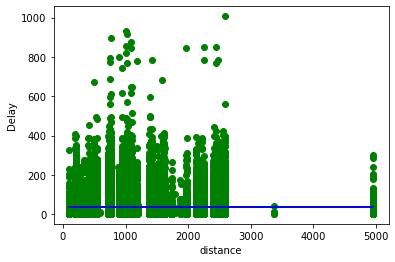

R^2 on train data is 0.032744467226592966 and on test data is 0.029405618327360106
The coefficents are [-0.00268046] and the intercept is -14.277652851055828
           arr_delay  distance
arr_delay   1.000000 -0.176971
distance   -0.176971  1.000000


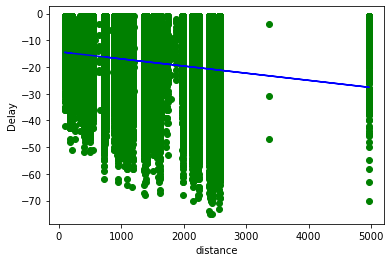

In [30]:
#JULIA

positive_delays = flights[flights['arr_delay']>0]
negative_delays = flights[flights['arr_delay']<0]

def plotRegression(feature,df):
    df = df.dropna(subset=[feature,'arr_delay'])
    X = df[[feature]]
    y = df['arr_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    ODS = LinearRegression()
    ODS.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train),ODS.score(X_test,y_test)))
    print("The coefficents are {} and the intercept is {}".format(ODS.coef_, ODS.intercept_))
    print(df[['arr_delay',feature]].corr())
    
    y_pred = ODS.predict(X)
    plt.scatter(X, y,color = "green") 
    plt.plot(X[feature], y_pred,color = "blue")
    plt.xlabel(feature)
    plt.ylabel("Delay")
    plt.show()

plotRegression('distance',flights) #All fligths 
plotRegression('distance',positive_delays)#flights with only positive delays
plotRegression('distance',negative_delays)#flights with only negative delays


### Conclusions
According to graphs above the arrival delay and distance are correlated almost only in case of negative delays. That means that flights flying further distances were deleyed less(so they arrived sooner) than flights flying short distances, but that's true mostly only for when the flights departed ealier than scheduled(3rd graph). For flights with regular(positive) delays there's hardly any correlation between delay time and distance(2nd graph). Concluding, there's very little correlation between two features and it's mostly influenced by negative delays. 

**(d)** Using OLS, investigate if departure delay is associated with arrival delay. Again,
   consider what to do with negative delays.

R^2 on train data is 0.7965460865263717 and on test data is 0.7906647024883411
The coefficents are [1.01274657] and the intercept is -7.417388777894841
           arr_delay  dep_delay
arr_delay    1.00000    0.89087
dep_delay    0.89087    1.00000


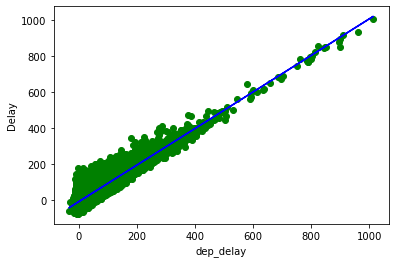

R^2 on train data is 0.8690006853075694 and on test data is 0.8729099919553227
The coefficents are [0.93268977] and the intercept is 4.297628297012203
           arr_delay  dep_delay
arr_delay   1.000000   0.933274
dep_delay   0.933274   1.000000


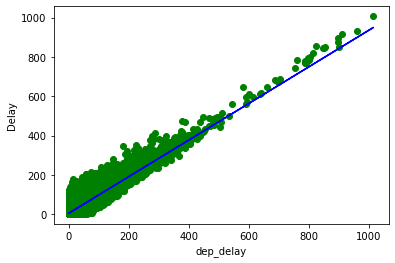

R^2 on train data is 0.011839811251317611 and on test data is 0.01329006860170523
The coefficents are [0.46206534] and the intercept is -16.43808823228722
           arr_delay  dep_delay
arr_delay   1.000000   0.113862
dep_delay   0.113862   1.000000


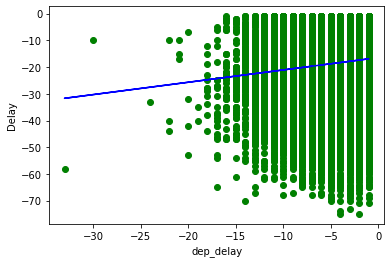

In [31]:
#JULIA

positive_delays = flights[((flights['dep_delay']>0) & (flights['arr_delay']>0))]
negative_delays = flights[((flights['dep_delay']<0) & (flights['arr_delay']<0))]

def plotRegression(feature,df):
    df = df.dropna(subset=[feature,'arr_delay'])
    X = df[[feature]]
    y = df['arr_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    ODS = LinearRegression()
    ODS.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train),ODS.score(X_test,y_test)))
    print("The coefficents are {} and the intercept is {}".format(ODS.coef_, ODS.intercept_))
    print(df[['arr_delay',feature]].corr())
    
    y_pred = ODS.predict(X)
    plt.scatter(X, y,color = "green") 
    plt.plot(X[feature], y_pred,color = "blue")
    plt.xlabel(feature)
    plt.ylabel("Delay")
    plt.show()

plotRegression('dep_delay',flights) #All fligths 
plotRegression('dep_delay',positive_delays)#flights with only positive delays
plotRegression('dep_delay',negative_delays)#flights with only negative delays



### Conclusions
The correlation between departure and arrival time is big in case of late flights but little in case of fligts that departed before expected time. So the correlations between these two is high but lowered by negative delays where arrival delay doesn't seem to be influenced by how early(earlier than expected time) the flight departed. It could be explained by fact that if flight departed ealier than expected it won't rush and usually land in planned time as it's probably scheduled and airports might not often allow early arrivals(it's just hypothesis :)). 

**(e)** Investigate whether departure delay is associated with weather conditions
   at the origin airport. This includes descriptives, plotting, regression modelling,
   considering missing values etc. For regression, do OLS, Ridge, Lasso, and Elastic Net.
   The analysis should also include seasonality trends as a "weather condition". You could,
   for instance, plot the daily departure delay with the date (or monthly). What are the
   three most important weather conditions when trying to predict departure delays?

In [32]:
#JULIA
display(flights.head())
display(weather.head())
#remove flights with no hour data - unable to be merged with weather data
flights_complete = flights.dropna(subset=['hour'])
#remove unrelated features
flights_complete = flights_complete.drop(columns=['carrier', 'tailnum','flight','dest','air_time','distance','arr_delay','arr_time','minute'])
flights_complete.info()
weather.info()

scaler = MinMaxScaler()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
3,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0
4,2013,1,1,554.0,-4.0,740.0,12.0,UA,N39463,1696,EWR,ORD,150.0,719,5.0,54.0


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,2.8,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,2.8,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,3.3,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,3.3,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,3.3,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z


<class 'pandas.core.frame.DataFrame'>
Int64Index: 158418 entries, 0 to 160753
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       158418 non-null  int64  
 1   month      158418 non-null  int64  
 2   day        158418 non-null  int64  
 3   dep_time   158418 non-null  float64
 4   dep_delay  158418 non-null  float64
 5   origin     158418 non-null  object 
 6   hour       158418 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 9.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26130 entries, 0 to 26129
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26130 non-null  object 
 1   year        26130 non-null  int64  
 2   month       26130 non-null  int64  
 3   day         26130 non-null  int64  
 4   hour        26130 non-null  int64  
 5   temp        26129 non-null  float64
 6   dewp        26129

In [33]:
#merging weather and flights data and leaving only ones with departure delay non-nan values
flight_weather = pd.merge(flights_complete, weather, how='outer', on=['origin', 'year','month','day','hour'])
flight_weather = flight_weather.drop(columns=['origin','time_hour','year'])
flight_weather = flight_weather.dropna(subset=['dep_delay'])


#flight_weather[feature] = scaler.fit_transform(flight_weather[[feature]])

flight_weather.head()
flight_weather.info()
flight_weather.describe()

flight_weather = flight_weather[flight_weather["wind_speed"] < 1000] #there's outlier that is probably error, because it's impossible for wind speed to be above 1000mph(The Highest Anemometer-Measured Wind Speeds on Earth, 2022)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158418 entries, 0 to 158417
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   month       158418 non-null  int64  
 1   day         158418 non-null  int64  
 2   dep_time    158418 non-null  float64
 3   dep_delay   158418 non-null  float64
 4   hour        158418 non-null  float64
 5   temp        157798 non-null  float64
 6   dewp        157798 non-null  float64
 7   humid       157798 non-null  float64
 8   wind_dir    154677 non-null  float64
 9   wind_speed  157792 non-null  float64
 10  wind_gust   157792 non-null  float64
 11  precip      157804 non-null  float64
 12  pressure    140679 non-null  float64
 13  visib       157804 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 18.1 MB


In [34]:
#now trying to get rid of missing value I'm using regression imputing for it
missing_columns = ["temp", "dewp", "humid", "wind_dir", "wind_speed","wind_gust","precip","pressure","visib"]
#firstly random impute missing values - we have multiple variables with missing values so some predictors woud be nan and it wouldn't work
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

for feature in missing_columns:
    flight_weather[feature + '_imp'] = flight_weather[feature]
    flight_weather = random_imputation(flight_weather, feature)
    
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

#using linear regression to input all the random imputed values with result of lin. regression for each feature with missing values
for feature in missing_columns:
        
    deter_data["Det" + feature] = flight_weather[feature + "_imp"]
    parameters = list(set(flight_weather.columns) - set(missing_columns) - {feature + '_imp'})
    model = LinearRegression()
    model.fit(X = flight_weather[parameters], y = flight_weather[feature + '_imp'])
    deter_data.loc[flight_weather[feature].isnull(), "Det" + feature] = model.predict(flight_weather[parameters])[flight_weather[feature].isnull()]
    flight_weather[feature] = deter_data["Det" + feature]
    flight_weather = flight_weather.drop(columns=[feature + "_imp"])
    

flight_weather.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 157778 entries, 10 to 158417
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   month       157778 non-null  int64  
 1   day         157778 non-null  int64  
 2   dep_time    157778 non-null  float64
 3   dep_delay   157778 non-null  float64
 4   hour        157778 non-null  float64
 5   temp        157778 non-null  float64
 6   dewp        157778 non-null  float64
 7   humid       157778 non-null  float64
 8   wind_dir    157778 non-null  float64
 9   wind_speed  157778 non-null  float64
 10  wind_gust   157778 non-null  float64
 11  precip      157778 non-null  float64
 12  pressure    157778 non-null  float64
 13  visib       157778 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 18.1 MB


## OLS

In [35]:
    X = flight_weather.drop(columns=['dep_delay'])
    y = flight_weather['dep_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    ODS = LinearRegression()
    ODS.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train),ODS.score(X_test,y_test)))
    print("the intercept is {}".format(ODS.intercept_))
    pd.Series(ODS.coef_, index=X.columns)
    

R^2 on train data is 0.10074106103559954 and on test data is 0.09956566658998056
the intercept is 226.61814365209628


month         -0.131555
day            0.044488
dep_time      -0.078080
hour          10.161899
temp          -0.785287
dewp           0.542268
humid          0.018024
wind_dir      -0.001613
wind_speed     0.058367
wind_gust      0.067167
precip        31.890118
pressure      -0.251335
visib         -0.361308
dtype: float64

#### Ploting OLS for each feature separately to see their correlation with dep delay time

In [36]:
def plotRegression(feature,flight_weather):
    #flight_weather[feature] = scaler.fit_transform(flight_weather[[feature]])
    X = flight_weather[[feature]]
    y = flight_weather['dep_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    ODS = LinearRegression()
    ODS.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train),ODS.score(X_test,y_test)))
    print(flight_weather[['dep_delay',feature]].corr())
    
    y_pred = ODS.predict(X)
    plt.scatter(X, y,color = "green") 
    plt.plot(X[feature], y_pred,color = "blue")
    plt.xlabel(feature)
    plt.ylabel("Delay")
    plt.show()


R^2 on train data is 2.604902789582475e-06 and on test data is 1.8041653111922074e-05
           dep_delay     month
dep_delay   1.000000 -0.004049
month      -0.004049  1.000000


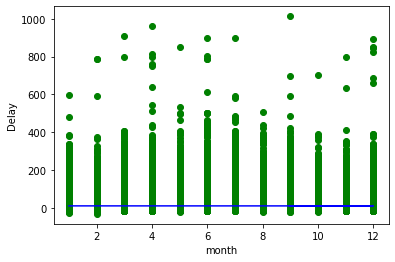

R^2 on train data is 1.0385410045832266e-05 and on test data is 5.5075189117959056e-05
           dep_delay       day
dep_delay   1.000000  0.006677
day         0.006677  1.000000


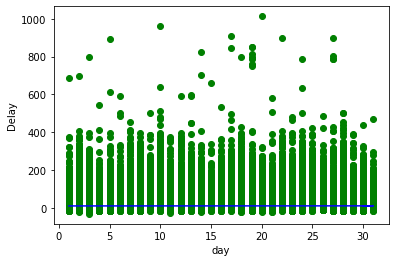

R^2 on train data is 0.06925841249332787 and on test data is 0.0710096366186499
           dep_delay  dep_time
dep_delay   1.000000  0.264808
dep_time    0.264808  1.000000


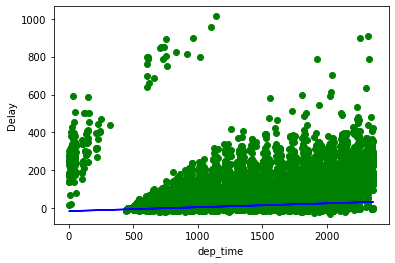

R^2 on train data is 1.0 and on test data is 1.0
           dep_delay  dep_delay
dep_delay        1.0        1.0
dep_delay        1.0        1.0


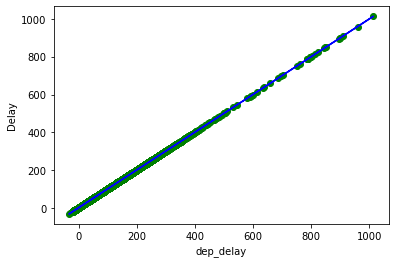

R^2 on train data is 0.0702803675402014 and on test data is 0.07191526684469918
           dep_delay      hour
dep_delay   1.000000  0.266623
hour        0.266623  1.000000


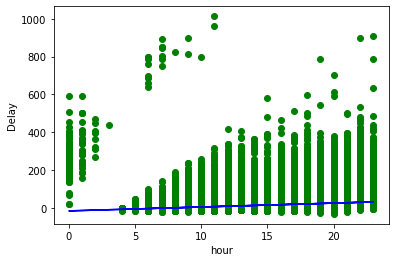

R^2 on train data is 0.011352245746489853 and on test data is 0.009550009678875981
           dep_delay      temp
dep_delay   1.000000  0.102398
temp        0.102398  1.000000


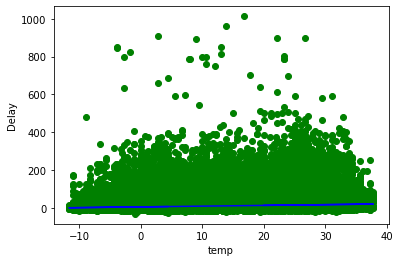

R^2 on train data is 0.011697232429599413 and on test data is 0.009346008584614873
           dep_delay      dewp
dep_delay   1.000000  0.102818
dewp        0.102818  1.000000


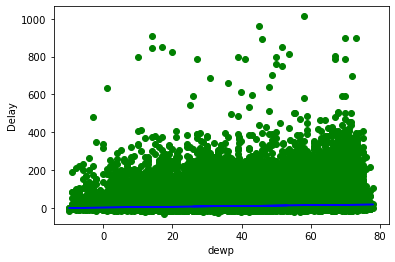

R^2 on train data is 0.001757062511052787 and on test data is 0.0010339093175532055
           dep_delay     humid
dep_delay   1.000000  0.037688
humid       0.037688  1.000000


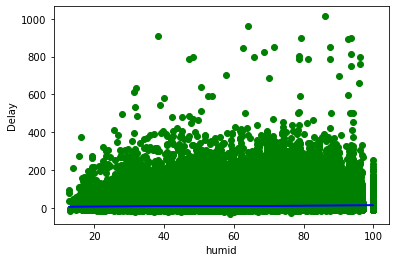

R^2 on train data is 0.0003784329817907439 and on test data is 0.00032553737400475846
           dep_delay  wind_dir
dep_delay   1.000000 -0.018796
wind_dir   -0.018796  1.000000


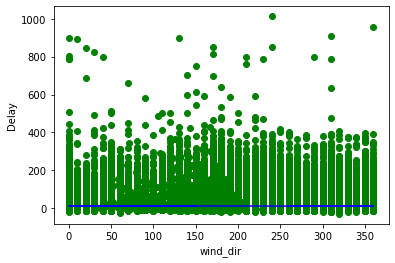

R^2 on train data is 0.0038912646317948996 and on test data is 0.004844122734088185
            dep_delay  wind_speed
dep_delay    1.000000    0.066127
wind_speed   0.066127    1.000000


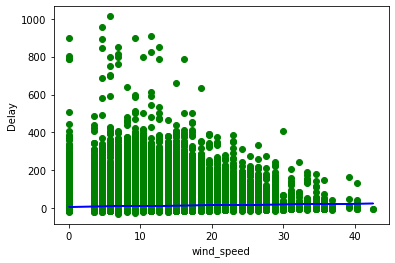

R^2 on train data is 0.0038912646317948996 and on test data is 0.004844122734088185
           dep_delay  wind_gust
dep_delay   1.000000   0.066127
wind_gust   0.066127   1.000000


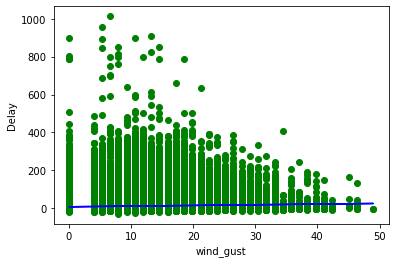

R^2 on train data is 0.0028820868297082525 and on test data is 0.0034898572979198406
           dep_delay    precip
dep_delay   1.000000  0.056434
precip      0.056434  1.000000


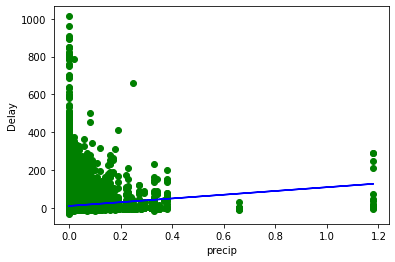

R^2 on train data is 0.010014564481968136 and on test data is 0.00858732515666416
           dep_delay  pressure
dep_delay   1.000000 -0.096583
pressure   -0.096583  1.000000


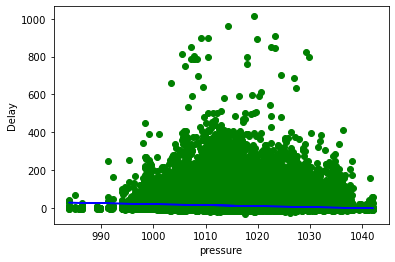

R^2 on train data is 0.008517466431148035 and on test data is 0.00873371520328503
           dep_delay     visib
dep_delay   1.000000 -0.092868
visib      -0.092868  1.000000


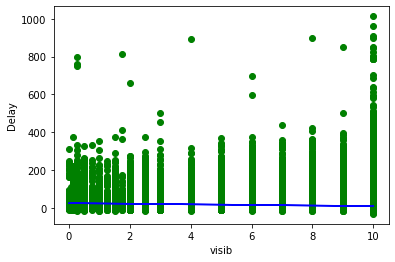

In [37]:
for feature in flight_weather.columns:
    plotRegression(feature,flight_weather)


R^2 on train data is 0.04774689307794877 and on test data is 0.04859518665351281
           dep_delay     month
dep_delay   1.000000  0.219468
month       0.219468  1.000000


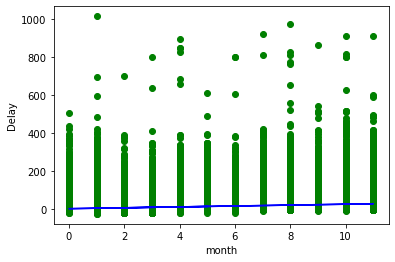

R^2 on train data is 0.10683748945901006 and on test data is 0.10929994389021047
           dep_delay      hour
dep_delay   1.000000  0.328715
hour        0.328715  1.000000


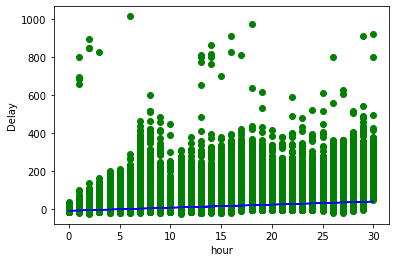

In [13]:
#Important to run this once only, if rerun needed then run data loading and preproccesing again
#the correlation for month might depend on which month we start counting from, so trying to plot it trying different months
flight_weather['month'] = flight_weather['month'] - 8
flight_weather[flight_weather['month']<0] = flight_weather[flight_weather['month']<0] + 12
plotRegression('month',flight_weather)
#same for hour
flight_weather['hour'] = flight_weather['hour'] - 5
flight_weather[flight_weather['hour']<0] = flight_weather[flight_weather['hour']<0] + 24
plotRegression('hour',flight_weather)

## Ridge



In [38]:
alphas = 10**np.linspace(-10, 10, 100)

for feature in flight_weather.columns:
    flight_weather[feature] = scaler.fit_transform(flight_weather[[feature]])

X = flight_weather.drop(columns=['dep_delay'])
y = flight_weather['dep_delay']
    
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
temp_coefficients = [coef[0] for coef in coefs]
dewp_coefficients = [coef[1] for coef in coefs]
humid_coefficients = [coef[2] for coef in coefs]
wind_dir_coefficients = [coef[3] for coef in coefs]
wind_speed_coefficients = [coef[4] for coef in coefs]
wind_gust_coefficients = [coef[5] for coef in coefs]
precip_coefficients = [coef[6] for coef in coefs]
pressure_coefficients = [coef[7] for coef in coefs]
visib_coefficients = [coef[8] for coef in coefs]
month_coefficients = [coef[9] for coef in coefs]
day_coefficients = [coef[10] for coef in coefs]

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

Text(0, 0.5, 'weights')

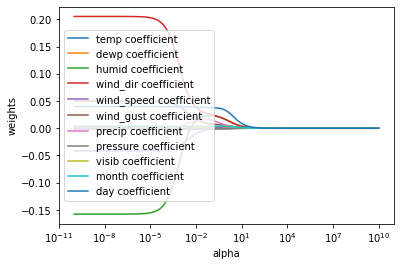

In [39]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, temp_coefficients, label="temp coefficient")
ax.plot(alphas, dewp_coefficients, label="dewp coefficient")
ax.plot(alphas, humid_coefficients, label="humid coefficient")
ax.plot(alphas, wind_dir_coefficients, label="wind_dir coefficient")
ax.plot(alphas, wind_speed_coefficients, label="wind_speed coefficient")
ax.plot(alphas, wind_gust_coefficients, label="wind_gust coefficient")
ax.plot(alphas, precip_coefficients, label="precip coefficient")
ax.plot(alphas, pressure_coefficients, label="pressure coefficient")
ax.plot(alphas, visib_coefficients, label="visib coefficient")
ax.plot(alphas, month_coefficients, label="month coefficient")
ax.plot(alphas, day_coefficients, label="day coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [40]:
    #alphas = 10**np.linspace(10,-2,100)*0.5
    X = flight_weather.drop(columns=['dep_delay'])
    y = flight_weather['dep_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

    ridgecv = RidgeCV( normalize = True)#alphas = alphas,
    ridgecv.fit(X_train, y_train)
    print(ridgecv.alpha_)   
    print("R^2 on train data is {} and on test data is {}  ".format(ridgecv.score(X_train, y_train), ridgecv.score(X_test,y_test)))
    pd.Series(ridgecv.coef_, index = X.columns)

0.1
R^2 on train data is 0.09786458312661739 and on test data is 0.0974315411821558  


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


month        -0.001172
day           0.001091
dep_time      0.023088
hour          0.025462
temp         -0.000798
dewp          0.008284
humid         0.015108
wind_dir     -0.000847
wind_speed    0.003058
wind_gust     0.003058
precip        0.034525
pressure     -0.013423
visib        -0.003721
dtype: float64

## Lasso

In [41]:
lasso = Lasso(max_iter = 10000, normalize = True)
X = flight_weather.drop(columns=['dep_delay'])
y = flight_weather['dep_delay']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)#alphas = None,
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))
pd.Series(lassocv.coef_, index=X.columns)

#lasso.set_params(alpha=lassocv.alpha_)
#lasso.fit(X_train, y_train)

#print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))
#pd.Series(lasso.coef_, index=X.columns)

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


3.3171692370758956e-08
R^2 on train data is 0.10052688115014397 and on test data is 0.09951979353305052


month        -0.001322
day           0.001240
dep_time     -0.114488
hour          0.163557
temp         -0.026316
dewp          0.034113
humid         0.006905
wind_dir     -0.000506
wind_speed    0.005499
wind_gust     0.000000
precip        0.035297
pressure     -0.013908
visib        -0.002958
dtype: float64

## Elastic Net

In [42]:

    X = flight_weather.drop(columns=['dep_delay'])
    y = flight_weather['dep_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    #cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=69)
    ratios = [.1, .2, .3 , .4, .5, .7, .8, .9, .95, .99, 1]
    #alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
    en = ElasticNetCV(l1_ratio=ratios, cv=10, n_jobs=-1)
    en.fit(X_train, y_train)
    print('alpha: %f' % en.alpha_)
    print('l1_ratio_: %f' % en.l1_ratio_)
    print("R^2 on train data is {} and on test data is {}".format(en.score(X_train, y_train),en.score(X_test,y_test)))

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009230960664837085, tolerance: 0.008741966762244513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009550178734926362, tolerance: 0.008774013630508327
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009215954044094588, tolerance: 0.008880470398617847
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011967797541430514, tolerance: 0.008811001991696436
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010498561664007866, tolerance: 0.008644654694357098
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014230656209790027, tolerance: 0.008811001991696436
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009085237606797136, tolerance: 0.008690946942591786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010314678825565693, tolerance: 0.008692480640398787
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012226162031907961, tolerance: 0.008692480640398787
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.046034411429275224, tolerance: 0.008644654694357098
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.048951827431878314, tolerance: 0.008644654694357098
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05185587379952494, tolerance: 0.008644654694357098
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05279385201036746, tolerance: 0.008741966762244513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05483591861535331, tolerance: 0.008741966762244513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056817545326182994, tolerance: 0.008741966762244513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05802622024717152, tolerance: 0.008690946942591786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0514132796164688, tolerance: 0.008774013630508327
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05353637297632474, tolerance: 0.008774013630508327
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05264912466140004, tolerance: 0.008864424621031033
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040023851641166175, tolerance: 0.008880470398617847
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.054328005175293015, tolerance: 0.008864424621031033
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056666305599037514, tolerance: 0.008811001991696436
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05742783725648337, tolerance: 0.008811001991696436
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05814233174595529, tolerance: 0.008811001991696436
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014603746988086641, tolerance: 0.008741966762244513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04264832119278594, tolerance: 0.008741966762244513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05103127711782918, tolerance: 0.008741966762244513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025344783973380913, tolerance: 0.0088564416837072
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04698512131848531, tolerance: 0.0088564416837072
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05305931190538615, tolerance: 0.0088564416837072
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024401283531062745, tolerance: 0.008690946942591786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04778504493712887, tolerance: 0.008690946942591786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05426007233592145, tolerance: 0.008690946942591786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026317389055520835, tolerance: 0.008690946942591786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044615685845457165, tolerance: 0.008864424621031033
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04955626339919661, tolerance: 0.008690946942591786
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04539363360423465, tolerance: 0.008864424621031033
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04405071013788131, tolerance: 0.008644654694357098
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04496736102217369, tolerance: 0.008811001991696436
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04424130338429677, tolerance: 0.008644654694357098
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020838622850519073, tolerance: 0.008741966762244513
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05593675512095331, tolerance: 0.008644654694357098
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0354560886793962, tolerance: 0.008692480640398787
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03420686979126231, tolerance: 0.0088564416837072
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053467527048127295, tolerance: 0.008692480640398787
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

alpha: 0.000002
l1_ratio_: 1.000000
R^2 on train data is 0.10026422842865623 and on test data is 0.09934125070557964


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+01, tolerance: 9.744e-03
  model = cd_fast.enet_coordinate_descent(


## Conclusions
After building regression on weather data with different models it's visible that the most 'influencial' parameter is hour. Top three are: hour, month and precip(now it depends on model). Weather conditions don't really influence deperture delay much therefore it's hard to build good regression model on it.

**(f)** Is the age of the plane associated with delay? Do OLS, Ridge, Lasso, and Elastic Net.

In [43]:
#NIKITA

# DATA PREPARATION 

planes_flights = pd.merge(planes, flights, how='outer', left_on = 'tailnum', right_on = 'tailnum')
planes_flights = planes_flights.drop(['type', 'manufacturer', 'seats', 'model', 'engines', 'speed', 'engine', 'carrier', 'flight', 'origin', 'dest', 'arr_time', 'dep_time', 'air_time', 'distance'], axis=1)
planes_flights['years'] = planes_flights['year_y']-planes_flights['year_x']
planes_flights['delay'] = planes_flights['dep_delay'] + (planes_flights['arr_delay'] - planes_flights['dep_delay'] )
planes_flights = planes_flights.drop(['arr_delay', 'dep_delay', 'year_x', 'year_y', 'month', 'day', 'hour', 'minute'], axis=1)

# taking average delay of each plane

planes_flights = planes_flights.groupby(['tailnum']).mean()
planes_flights = planes_flights.reset_index()
planes_flights = planes_flights.drop(['tailnum'], axis=1)

planes_flights = planes_flights.dropna(subset=['years'])

planes_flights = planes_flights.sort_values(by=['delay'])

#X = result['delay'].array.reshape(-1, 1)
#y = result['years']

#X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [44]:
#now trying to get rid of missing value I'm using regression imputing for it
missing_columns = ["delay"]
#firstly random impute missing values - we have multiple variables with missing values so some predictors woud be nan and it wouldn't work
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

for feature in missing_columns:
    planes_flights[feature + '_imp'] = planes_flights[feature]
    planes_flights = random_imputation(planes_flights, feature)
    
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

#using linear regression to input all the random imputed values with result of lin. regression for each feature with missing values
for feature in missing_columns:
        
    deter_data["Det" + feature] = planes_flights[feature + "_imp"]
    parameters = list(set(planes_flights.columns) - set(missing_columns) - {feature + '_imp'})
    model = LinearRegression()
    model.fit(X = planes_flights[parameters], y = planes_flights[feature + '_imp'])
    deter_data.loc[planes_flights[feature].isnull(), "Det" + feature] = model.predict(planes_flights[parameters])[planes_flights[feature].isnull()]
    planes_flights[feature] = deter_data["Det" + feature]
    planes_flights = planes_flights.drop(columns=[feature + "_imp"])
    

planes_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1714 entries, 2012 to 3597
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   years   1714 non-null   float64
 1   delay   1714 non-null   float64
dtypes: float64(2)
memory usage: 40.2 KB


In [45]:
# Correlation of years/delay

print(planes_flights[['years','delay']].corr())

          years     delay
years  1.000000  0.080981
delay  0.080981  1.000000


In [46]:
def plotRegression(X_train,y_train):
    plt.scatter(X_train, y_train, color='red') # plotting the observation line
    plt.plot(X_train, lr.predict(X_train), color='blue') # plotting the regression line
    plt.title("(Training set)") # stating the title of the graph
    plt.xlabel("Delay") # adding the name of x-axis
    plt.ylabel("Ages") # adding the name of y-axis
    plt.show() # specifies end of graph

lr.coef_: [0.01743494]
lr.intercept_: 15.293392314324041
Training set score (R2): 0.002115
Test set score: 0.006083
Difference in training and test set score signs of overfiting


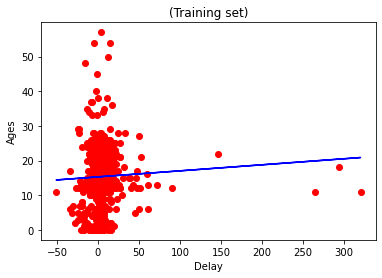

In [47]:
## OLS

X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("Training set score (R2): {:.6f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.6f}".format(lr.score(X_test, y_test)))
print('Difference in training and test set score signs of overfiting')

## making graph
plotRegression(X_train,y_train)

In [48]:
#Ridge
alphas = 10**np.linspace(-10, 10, 100)
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

np.shape(coefs)
_coefficients = [coef[0] for coef in coefs]

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

Text(0, 0.5, 'weights')

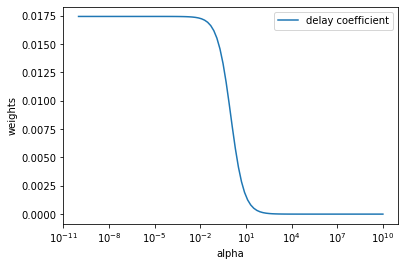

In [49]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, _coefficients, label="delay coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


1.0
R^2 on train data is 0.0015859742667260202 and on test data is 0.001968746312258407  


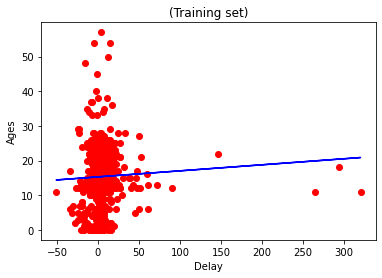

In [50]:
X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

ridgecv = RidgeCV(normalize = True)#alphas = alphas,
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)   
print("R^2 on train data is {} and on test data is {}  ".format(ridgecv.score(X_train, y_train), ridgecv.score(X_test,y_test)))

## making graph
plotRegression(X_train,y_train)

Training set score: 0.000796
Test set score: -0.000790
Number of features used: 1


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


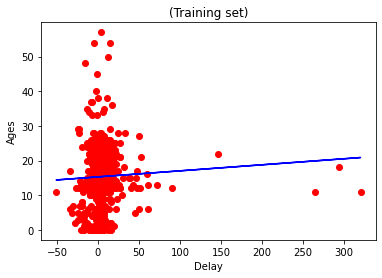

In [51]:
#Lasso
X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

#we increase the default setting of "max_iter",
#otherwise the model would warn us that we should increase max_iter.
lasso = Lasso(alpha=0.01, max_iter=10000, normalize = True).fit(X_train, y_train)
print("Training set score: {:.6f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.6f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

## making graph
plotRegression(X_train,y_train)

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


0.012663913170055384
R^2 on train data is 0.0 and on test data is -0.0029671335273051547


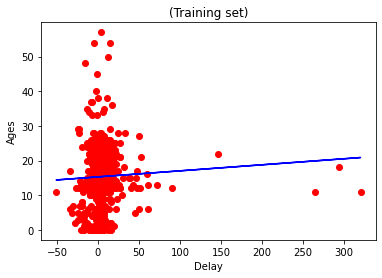

In [52]:
#LassoCV
X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)#alphas = None,
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))

## making graph
plotRegression(X_train,y_train)

alpha: 78.830857
l1_ratio_: 0.100000
R^2 on train data is 0.0 and on test data is -0.0029671335273051547


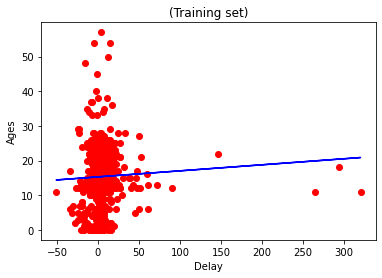

In [53]:
# ElasticNet
X = planes_flights['delay'].array.reshape(-1, 1)
y = planes_flights['years']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=69)
ratios = [.1, .2, .3 , .4, .5, .7, .8, .9, .95, .99, 1]
#alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
en = ElasticNetCV(l1_ratio=ratios, cv=10, n_jobs=-1)
en.fit(X_train, y_train)

print('alpha: %f' % en.alpha_)
print('l1_ratio_: %f' % en.l1_ratio_)
print("R^2 on train data is {} and on test data is {}".format(en.score(X_train, y_train),en.score(X_test,y_test)))

## making graph
plotRegression(X_train,y_train)




**(g)** Do a principal component analysis of the weather at JFK using the following columns:
   temp, dewp, humid, wind_dir, wind_speed, precip, visib.
   How many principal components should be used to capture the variability in the weather data?

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,2.8,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,2.8,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,3.3,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,3.3,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,3.3,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26125,LGA,2013,12,30,19,2.2,19.94,51.78,340.0,13.80936,15.891535,0.0,1017.1,10.0,2013-12-30T19:00:00Z
26126,LGA,2013,12,30,20,1.1,17.06,49.51,330.0,17.26170,19.864419,0.0,1018.8,10.0,2013-12-30T20:00:00Z
26127,LGA,2013,12,30,21,0.0,15.08,49.19,340.0,14.96014,17.215830,0.0,1019.5,10.0,2013-12-30T21:00:00Z
26128,LGA,2013,12,30,22,-0.6,12.92,46.74,320.0,17.26170,19.864419,0.0,1019.9,10.0,2013-12-30T22:00:00Z


array([[ 2.8    , 21.92   , 53.97   , ..., 10.35702,  0.     , 10.     ],
       [ 2.8    , 21.92   , 53.97   , ..., 13.80936,  0.     , 10.     ],
       [ 3.3    , 21.92   , 52.09   , ..., 12.65858,  0.     , 10.     ],
       ...,
       [ 0.     , 15.08   , 49.19   , ..., 14.96014,  0.     , 10.     ],
       [-0.6    , 12.92   , 46.74   , ..., 17.2617 ,  0.     , 10.     ],
       [-1.7    , 10.94   , 46.41   , ..., 18.41248,  0.     , 10.     ]])

array(['EWR', 'EWR', 'EWR', ..., 'LGA', 'LGA', 'LGA'], dtype=object)

variance explained by all 7 principal components = 100.0
variance explained by the First principal component = 34.44166410062211
variance explained by the 2 principal component = 56.619275244181225
variance explained by the 3 principal component = 72.21257346879487
variance explained by the 4 principal component = 82.84070332775292
variance explained by the 5 principal component = 92.96747389582134
variance explained by the 6 principal component = 99.96106204289795
variance explained by the 7 principal component = 100.0


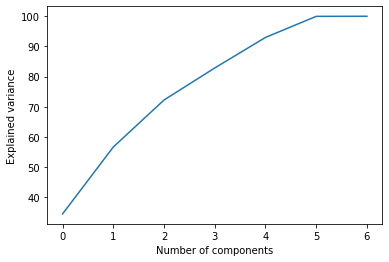

In [55]:
# Nikita 
features = ['temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'precip', 'visib']
weather_to_use = weather.dropna()

display(weather_to_use)

# Separating out the features
X = weather_to_use.loc[:, features].values
display(X)
# Separating out the origin
y = weather_to_use['origin'].values
display(y)
# Splitting the X and Y into the
sc = StandardScaler()
# Standardizing the features
sc.fit(X)
X_scaled = sc.transform(X)

# Applying PCA 
# 7 components sa the number of features we have
pca = decomposition.PCA(n_components = 7)
pca.fit(X_scaled)
X_pca_7 = pca.transform(X_scaled)

print("variance explained by all 7 principal components =", sum(pca.explained_variance_ratio_ * 100))

plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('elbow_plot.png', dpi=100)

print("variance explained by the First principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[0])

print("variance explained by the 2 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[1])

print("variance explained by the 3 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[2])

print("variance explained by the 4 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[3])

print("variance explained by the 5 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[4])

print("variance explained by the 6 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[5])

print("variance explained by the 7 principal component =", 
      np.cumsum(pca.explained_variance_ratio_ * 100)[6])

# It is not possible to create a scatterplot for the original datase because it contains 7 features.
# We can make 2D and 3D scatterplots, but in this case we will lose some variability
# For 2D scatterplot we will have 56.6...% variability
# For 3D scatterplot we will have 72.2...% variability 

# Variance after 5 porincipal componenet are not changing significantlty 

# Select the best number of principal components while keeping as much of the variance in the original data as possible.

# We can choose 5 prncipal components to capture the variability in the weather data


**(h)** Build regression models (OLS, Ridge, Lasso, and Elastic Net) that associates
   an airports lattitude with weather conditions (temp, dewp, humid, wind_dir, wind_speed,
   precip, visib). Remove all but the three most significant whether conditions and redo
   the analysis.

In [56]:
# Nikita 
# Data Preparation
data = pd.merge(airports, weather, how='outer', left_on = 'faa', right_on = 'origin')
data = data.drop(columns = ['year', 'month', 'day', 'hour','lon', 'alt', 'tz', 'dst', 'tzone', 'origin', 'name', 'time_hour', 'pressure', 'wind_gust', 'faa'])
display(data)
data = data.dropna(subset=['lat'])
data = data[data["wind_speed"] < 1000]


,lat,temp,dewp,humid,wind_dir,wind_speed,precip,visib
0,41.130472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32.460572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41.989341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41.431912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31.074472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
27580,35.083228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27581,41.298669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27582,39.736667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27583,38.897460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
#now trying to get rid of missing value I'm using regression imputing for it
missing_columns = ["temp", "dewp", "humid", "wind_dir", "wind_speed","precip","visib"]
#firstly random impute missing values - we have multiple variables with missing values so some predictors woud be nan and it wouldn't work

for feature in missing_columns:
    data[feature + '_imp'] = data[feature]
    data = random_imputation(data, feature)
    
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

#using linear regression to input all the random imputed values with result of lin. regression for each feature with missing values
for feature in missing_columns:
        
    deter_data["Det" + feature] = data[feature + "_imp"]
    parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imp'})
    model = LinearRegression()
    model.fit(X = data[parameters], y = data[feature + '_imp'])
    deter_data.loc[data[feature].isnull(), "Det" + feature] = model.predict(data[parameters])[data[feature].isnull()]
    data[feature] = deter_data["Det" + feature]
    data = data.drop(columns=[feature + "_imp"])
    

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26126 entries, 460 to 26913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         26126 non-null  float64
 1   temp        26126 non-null  float64
 2   dewp        26126 non-null  float64
 3   humid       26126 non-null  float64
 4   wind_dir    26126 non-null  float64
 5   wind_speed  26126 non-null  float64
 6   precip      26126 non-null  float64
 7   visib       26126 non-null  float64
dtypes: float64(8)
memory usage: 1.8 MB


In [58]:
# OLS 

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
lr = LinearRegression()
lr.fit(X_train, y_train)

print("R^2 on train data is {} and on test data is {}".format(lr.score(X_train, y_train),lr.score(X_test,y_test)))
print("the intercept is {}".format(lr.intercept_))
pd.Series(lr.coef_, index=X.columns)
    

R^2 on train data is 0.03677293870750975 and on test data is 0.03378799270275046
the intercept is 40.813753928722434


temp         -0.005863
dewp          0.003584
humid        -0.002274
wind_dir     -0.000015
wind_speed   -0.000874
precip        0.021464
visib        -0.003199
dtype: float64

In [59]:
def plotOLSRegression(feature, data):
    X = data[[feature]]
    y = data['lat']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(lr.score(X_train, y_train),lr.score(X_test,y_test)))
    print(data[['lat',feature]].corr())
    
    y_pred = lr.predict(X)
    plt.scatter(X,y,color = "green") 
    plt.plot(X[feature], y_pred,color = "blue")
    plt.xlabel(feature)
    plt.ylabel("Lat")
    plt.show()

R^2 on train data is 1.0 and on test data is 1.0
     lat  lat
lat  1.0  1.0
lat  1.0  1.0


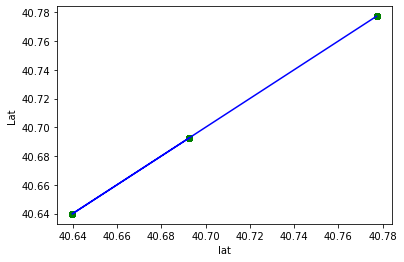

R^2 on train data is 0.00030068063331245565 and on test data is 0.0009460985876477146
          lat     temp
lat   1.00000  0.02772
temp  0.02772  1.00000


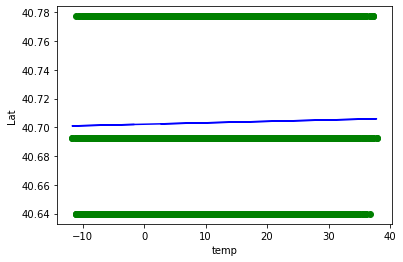

R^2 on train data is 0.0014076241944321888 and on test data is -8.987095773616005e-05
          lat     dewp
lat   1.00000 -0.02806
dewp -0.02806  1.00000


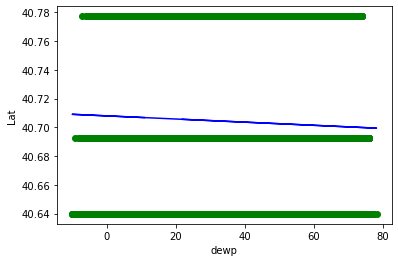

R^2 on train data is 0.016548724403620207 and on test data is 0.015649687924883415
            lat     humid
lat    1.000000 -0.127012
humid -0.127012  1.000000


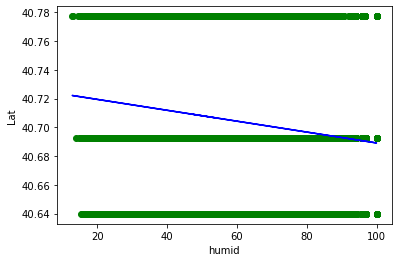

R^2 on train data is 0.0001301717061082952 and on test data is 0.0002303449014376957
               lat  wind_dir
lat       1.000000 -0.015283
wind_dir -0.015283  1.000000


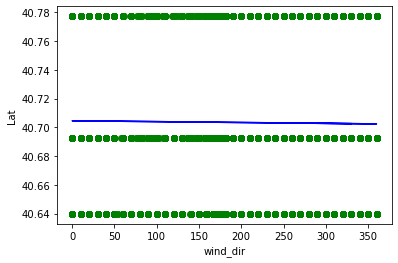

R^2 on train data is 0.0022143012026115683 and on test data is 0.001331732089351445
                 lat  wind_speed
lat         1.000000   -0.042797
wind_speed -0.042797    1.000000


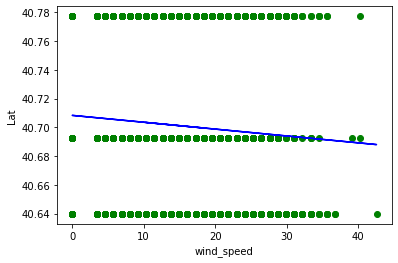

R^2 on train data is 0.00027497813132371096 and on test data is -0.0003448459657260372
             lat    precip
lat     1.000000 -0.008406
precip -0.008406  1.000000


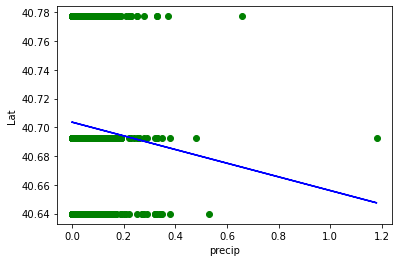

R^2 on train data is 0.0006498284126313925 and on test data is 0.0004010566011162231
            lat     visib
lat    1.000000  0.023828
visib  0.023828  1.000000


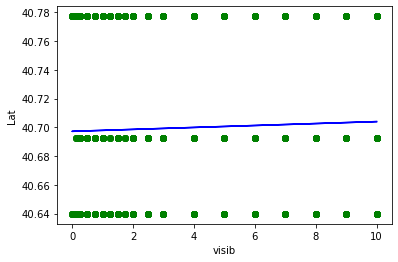

In [60]:
#OLS

for feature in data.columns:
    plotOLSRegression(feature,data)

In [61]:
#Ridge

alphas = 10**np.linspace(-10, 10, 100)

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
temp_coefficients = [coef[0] for coef in coefs]
dewp_coefficients = [coef[1] for coef in coefs]
humid_coefficients = [coef[2] for coef in coefs]
wind_dir_coefficients = [coef[3] for coef in coefs]
wind_speed_coefficients = [coef[4] for coef in coefs]
precip_coefficients = [coef[5] for coef in coefs]
visib_coefficients = [coef[6] for coef in coefs]

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

Text(0, 0.5, 'weights')

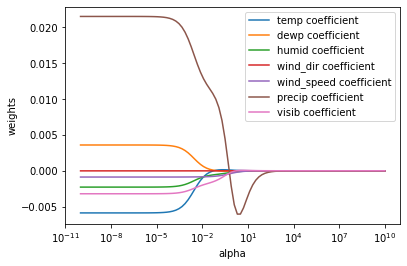

In [62]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, temp_coefficients, label="temp coefficient")
ax.plot(alphas, dewp_coefficients, label="dewp coefficient")
ax.plot(alphas, humid_coefficients, label="humid coefficient")
ax.plot(alphas, wind_dir_coefficients, label="wind_dir coefficient")
ax.plot(alphas, wind_speed_coefficients, label="wind_speed coefficient")
ax.plot(alphas, precip_coefficients, label="precip coefficient")
ax.plot(alphas, visib_coefficients, label="visib coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [63]:
#RidgeCV

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

ridgecv = RidgeCV(normalize = True)
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)   
print("R^2 on train data is {} and on test data is {}  ".format(ridgecv.score(X_train, y_train), ridgecv.score(X_test,y_test)))
pd.Series(ridgecv.coef_, index = X.columns)

0.1
R^2 on train data is 0.02782966671526166 and on test data is 0.026894506028586562  


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


temp          0.000102
dewp          0.000004
humid        -0.000493
wind_dir     -0.000013
wind_speed   -0.000726
precip        0.009374
visib        -0.001277
dtype: float64

In [64]:
#Lasso

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
lasso = Lasso(alpha = 8.3,max_iter = 10000, normalize = True)#alphas = None,
lasso.fit(X_train, y_train)
print("R^2 on train data is {} and on test data is {}".format(lasso.score(X_train, y_train),lasso.score(X_test,y_test)))

R^2 on train data is 0.0 and on test data is -7.807372411261504e-05


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [65]:
#LassoCV

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)#alphas = None,
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))

pd.Series(lassocv.coef_, index=X.columns)

6.382816015389226e-08
R^2 on train data is 0.03675554892190491 and on test data is 0.03388713456433878


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


temp         -0.005588
dewp          0.003420
humid        -0.002195
wind_dir     -0.000015
wind_speed   -0.000871
precip        0.020659
visib        -0.003129
dtype: float64

In [66]:
# Elastic Net CV

X = data.loc[:,'temp':'visib']
y = data['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=69)
ratios = [.1, .2, .3 , .4, .5, .7, .8, .9, .95, .99, 1]
#alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
en = ElasticNetCV(l1_ratio=ratios, cv=10, n_jobs=-1)
en.fit(X_train, y_train)
print('alpha: %f' % en.alpha_)
print('l1_ratio_: %f' % en.l1_ratio_)
print("R^2 on train data is {} and on test data is {}".format(en.score(X_train, y_train),en.score(X_test, y_test)))
pd.Series(en.coef_, index=X.columns)

alpha: 0.000141
l1_ratio_: 1.000000
R^2 on train data is 0.03667920843745909 and on test data is 0.03372950722006407


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e-01, tolerance: 4.201e-03
  model = cd_fast.enet_coordinate_descent(


temp         -0.005420
dewp          0.003319
humid        -0.002144
wind_dir     -0.000015
wind_speed   -0.000858
precip        0.000000
visib        -0.003104
dtype: float64

In [67]:
# Remove all but the three most significant whether conditions and redo the analysis.
# temp, dewp, humid, wind_dir, wind_speed, precip, visib

# dewp, precip, visib have more significant change after doing ElasticNetCV 

data_upd = data.drop(['temp', 'wind_speed', 'humid', 'wind_dir'], axis=1)

data_upd



X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


In [68]:
#OLS
X = data_upd.loc[:,'dewp':'visib']
y = data_upd['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
lr = LinearRegression()
lr.fit(X_train, y_train)

print("R^2 on train data is {} and on test data is {}".format(lr.score(X_train, y_train),lr.score(X_test,y_test)))
print("the intercept is {}".format(lr.intercept_))
pd.Series(lr.coef_, index=X.columns)

R^2 on train data is 0.0018986634933088054 and on test data is 0.00011729401206495016
the intercept is 40.70325975007279


dewp     -0.000101
precip   -0.024773
visib     0.000478
dtype: float64

R^2 on train data is 1.0 and on test data is 1.0
     lat  lat
lat  1.0  1.0
lat  1.0  1.0


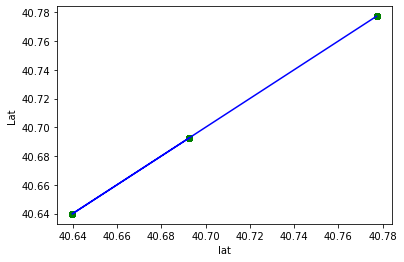

R^2 on train data is 0.0014076241944321888 and on test data is -8.987095773616005e-05
          lat     dewp
lat   1.00000 -0.02806
dewp -0.02806  1.00000


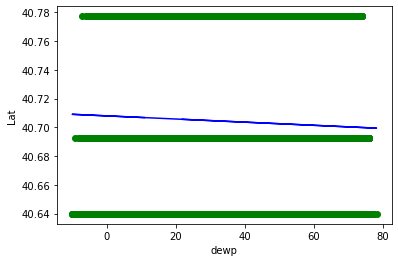

R^2 on train data is 0.00027497813132371096 and on test data is -0.0003448459657260372
             lat    precip
lat     1.000000 -0.008406
precip -0.008406  1.000000


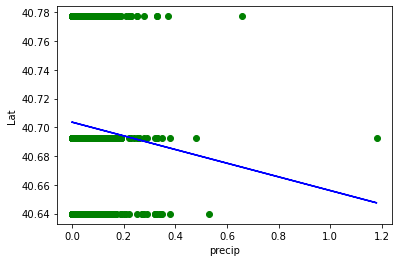

R^2 on train data is 0.0006498284126313925 and on test data is 0.0004010566011162231
            lat     visib
lat    1.000000  0.023828
visib  0.023828  1.000000


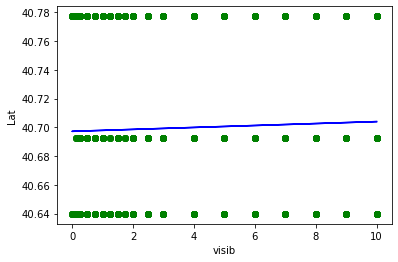

In [69]:
for feature in data_upd.columns:
    plotOLSRegression(feature,data_upd)

In [70]:
#Ridge

X = data_upd.loc[:,'dewp':'visib']
y = data_upd['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

ridgecv = RidgeCV(normalize = True)
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)   
print("R^2 on train data is {} and on test data is {}  ".format(ridgecv.score(X_train, y_train), ridgecv.score(X_test,y_test)))
pd.Series(ridgecv.coef_, index = X.columns)


0.1
R^2 on train data is 0.0018870286323964258 and on test data is 0.0002332702119464125  


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


dewp     -0.000092
precip   -0.023997
visib     0.000447
dtype: float64

In [71]:
#Lasso

X = data_upd.loc[:,'dewp':'visib']
y = data_upd['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)#alphas = None,
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))

pd.Series(lassocv.coef_, index=X.columns)


9.934503179527345e-08
R^2 on train data is 0.0018985733263082727 and on test data is 0.00012937206052110461


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


dewp     -0.000100
precip   -0.024349
visib     0.000475
dtype: float64

In [72]:
# Elastic Net
X = data_upd.loc[:,'dewp':'visib']
y = data_upd['lat']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=69)
ratios = [.1, .2, .3 , .4, .5, .7, .8, .9, .95, .99, 1]
#alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
en = ElasticNetCV(l1_ratio=ratios, cv=10, n_jobs=-1)
en.fit(X_train, y_train)
print('alpha: %f' % en.alpha_)
print('l1_ratio_: %f' % en.l1_ratio_)
print("R^2 on train data is {} and on test data is {}".format(en.score(X_train, y_train),en.score(X_test, y_test)))
pd.Series(en.coef_, index=X.columns)



alpha: 0.000414
l1_ratio_: 0.100000
R^2 on train data is 0.0018317097277502636 and on test data is 0.0003176377922182727


dewp     -0.000101
precip   -0.000000
visib     0.000543
dtype: float64

**(i)** On a map, plot the airports that have flights to them where the points that represent
   airports are relative in size to the average departure delay. You can see an example in "airports.png".

<AxesSubplot:>

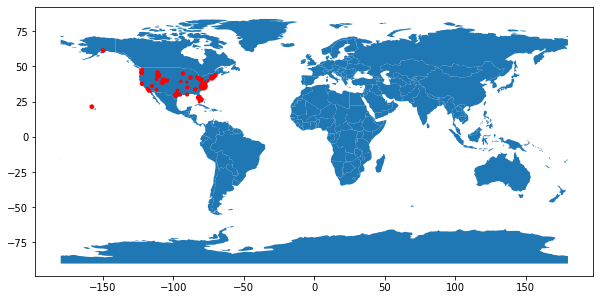

In [73]:
# Nikita

data_map = pd.merge(airports, flights, how='outer', left_on = 'faa', right_on = 'dest')
data_map = data_map.dropna()

data_map = data_map.drop(['dep_time', 'arr_time', 'arr_delay', 'carrier', 'tailnum', 'flight', 'origin', 'dest', 'air_time', 'distance', 'tzone', 'tz', 'alt', 'name', 'faa', 'hour', 'minute', 'year', 'month', 'day', 'dst'], axis=1)

data_map = data_map.groupby(['lat', 'lon']).mean()

data_map = data_map.reset_index()

positive_delays = data_map[(data_map['dep_delay']>0)]

geometry = [Point(xy) for xy in zip(positive_delays['lon'], positive_delays['lat'])]
gdf = GeoDataFrame(positive_delays, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=positive_delays['dep_delay'])





 **(j)** These questions require no code.
 - Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter or reduce it?

- Why would you want to use:
        > Ridge Regression instead of plain Linear Regression (i.e. without any regularization)?
        > Lasso instead of Ridge Regression?
        > Elastic Net instead of Lasso?

In [74]:
# Nikita
# Suppose you are using Ridge Regression and you notice that the training error and the validation 
# error are almost equal and fairly high. Would you say that the model suffers from high bias or high 
# variance? Should you increase the regularization hyperparameter or reduce it?

# When the training error and validation error are close to each other and high that means your model 
# is underfitting (i.e. it has high bias). You should try to reduce the regularization hyperparameter.

In [75]:
#Why would you want to use:

#Ridge Regression instead of plain Linear Regression (i.e. without any regularization)?

#When you have features in your dataset that are highly linearly correlated with other features, 
#turns out linear models will be likely to overfit. Ridge Regression, avoids over fitting 
#by adding a penalty to models that have too large coefficients.

#Lasso instead of Ridge Regression?

#Lasso tends to do well if there are a small number of significant parameters and the others 
#are close to zero.

# Elastic Net instead of Lasso?

#Elastic Net combines feature elimination from Lasso and feature coefficient reduction from 
#the Ridge model to improve your model's predictions.


## 3. Clustering of Handwritten Digits

__You should be able to do this exercise after Lecture 5.__

This exercise will depart from the famous MNIST dataset, and we are exploring several clustering techniques with it.. This is a ".mat" file, in order to load this file in an ipynb you have to use loadmat() function from scipy.io. (replace my path).

In [76]:
import cv2 as cv
from scipy.io import loadmat
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np

mnist = loadmat('datasets/3/mnist-original')
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

print("Number of datapoints: {}\n".format(mnist_data.shape[0]))
print("Number of features: {}\n".format(mnist_data.shape[1]))
print("List of labels: {}\n".format(np.unique(mnist_label)))

Number of datapoints: 70000

Number of features: 784

List of labels: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]



In [77]:
# Data Preparation
def normalize_pixel(pixel):
    return round(pixel / 255, 3);

def normalize_img(img):
    img_normal = np.array(list(map(normalize_pixel, img)))
    return img_normal

normalized_images = []
for img in mnist_data:
    normalized_images.append(normalize_img(img))  

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels,
and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s `imshow()` function:

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
index = 7
print("Value of datapoint no. {}:\n{}\n".format(index,clustered_images[index]))
print("As image:\n")
plt.imshow(clustered_images[index].reshape(28,28),cmap=plt.cm.gray_r)
plt.show()

NameError: name 'clustered_images' is not defined

**(a)** Perform k-means clustering with k=10 on this dataset.

In [79]:
clusters = KMeans(n_clusters=10, init='k-means++', random_state = 69).fit(normalized_images)
labels = clusters.labels_

accuracy = accuracy_score(mnist_label, labels);
print(
    "The accuracy is :",
    accuracy,
)

The accuracy is : 0.14921428571428572


**(b)** Using visualization techniques analogous to what we have done in the Clustering notebook
   for the faces data, can you determine the 'nature' of the 10 constructed clusters?
   Do the clusters (roughly) coincide with the 10 different actual digits?

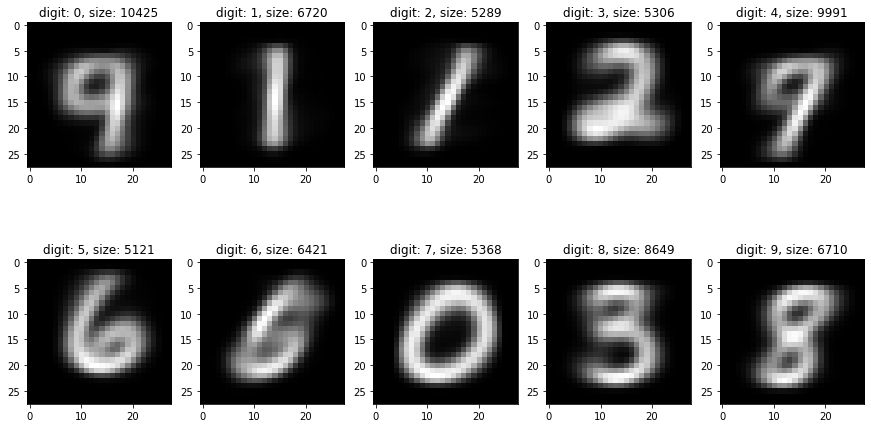

In [80]:
fig,axes = plt.subplots(2,5, figsize=(15, 8))
for ax,cc,i in zip (axes.ravel(),clusters.cluster_centers_,np.arange(axes.ravel().size)):
    ax.set_title("digit: {}, size: {}".format(i,len(np.where(clusters.labels_==i)[0])))
    ax.imshow(cc.reshape(28,28),cmap='gray')
plt.show()

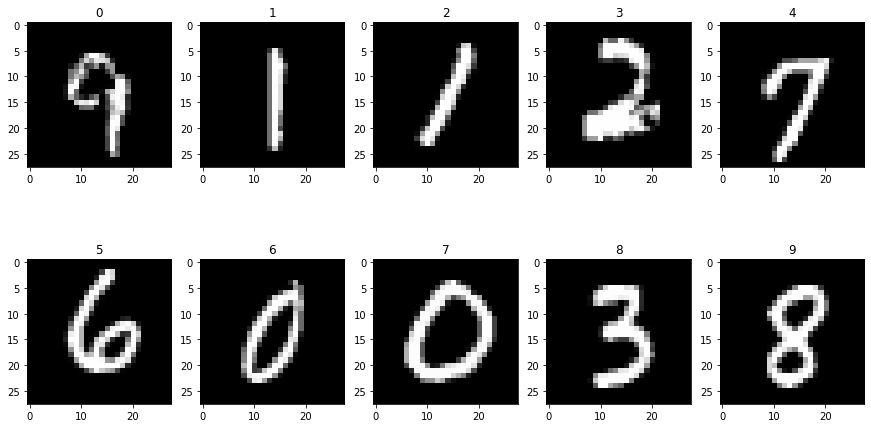

In [81]:
distances = clusters.transform(normalized_images)

pseudo_medoids=np.argmin(distances,axis=0)
fig,axes = plt.subplots(2,5,figsize=(15,8))
for ax,pm,i in zip (axes.ravel(),pseudo_medoids,np.arange(axes.ravel().size)):
    ax.set_title(i)
    ax.imshow(normalized_images[pm].reshape(28,28),cmap='gray')
plt.show()

**(c)** Perform a supervised clustering evaluation using adjusted rand index.
   Are the results stable, when you perform several random restarts of k-means?

In [82]:
for rand_index in range(1,10):
    clusters = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state = rand_index).fit(normalized_images)
    labels = clusters.labels_
    accuracy = accuracy_score(mnist_label, labels);
    print(
        "For rand_index =",
        rand_index,
        "; accuracy = ",
        accuracy
    )

For rand_index = 1 ; accuracy =  0.3087
For rand_index = 2 ; accuracy =  0.17852857142857143
For rand_index = 3 ; accuracy =  0.08607142857142858
For rand_index = 4 ; accuracy =  0.04717142857142857
For rand_index = 5 ; accuracy =  0.1634
For rand_index = 6 ; accuracy =  0.09387142857142858
For rand_index = 7 ; accuracy =  0.08154285714285714
For rand_index = 8 ; accuracy =  0.1400142857142857
For rand_index = 9 ; accuracy =  0.023742857142857142


**(d)** Now perform hierarchical clustering on the data.
   (in order to improve visibility in the constructed dendrograms, you can also use a
   much reduced dataset as constructed using sklearn.utils.resample shown below).
   Does the visual analysis of the dendrogram indicate a natural number of clusters?

**(e)** Using different cluster distance metrics (ward,single,average, etc.),
   what do the clusterings look like that are produced at the level of k=10 clusters?
   See the Clustering notebook for the needed Python code, including the fcluster
   method to retrieve 'plain' clusterings from the hierarchical clustering.

In [83]:
small_mnist_data,small_mnist_label = skl.utils.resample(mnist.data,mnist.target,n_samples=200,replace='false')

NameError: name 'skl' is not defined

**(f)** Do a DBSCAN clustering of the small dataset. Tweak the different parameters.

In [84]:
def plotCluster(clusters, X_scaled):
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, s=60)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    print("Unique groups: {}".format(np.unique(clusters)))

In [85]:
from sklearn.datasets import make_moons, make_blobs
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=200, noise=0.07, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [86]:
# parameters
# epsilon - local radius for expanding clusters
# min_samples - the fewest number of points required to form a cluster
# unique groups show an array of unique formed groups. If array containing -1 number, means there is noise. 


Unique groups: [0]


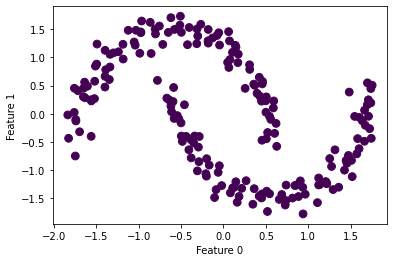

In [87]:
# DBSCAN clustering without parameters / default epsilon is 0.5 and min_samples are 4
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)


In [88]:
# Epsilon 0.5 is too big. So it's forming only one group 

Unique groups: [-1  0  1]


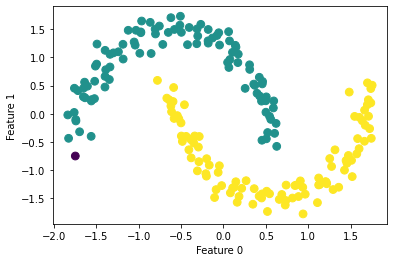

In [89]:
# DBSCAN clustering with eps 0.3 and default min_samples = 4
dbscan = DBSCAN(eps = 0.3)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [90]:
# Now it's possible to see two groups and one sample of noise. 

Unique groups: [0 1]


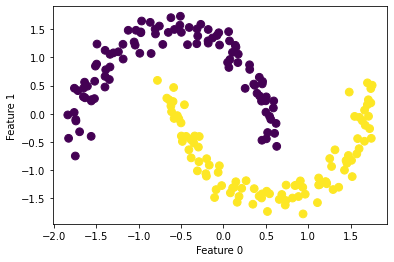

In [91]:
# DBSCAN clustering with eps 0.4 and min_samples = 3
dbscan = DBSCAN(eps = 0.4, min_samples = 3)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [92]:
# With eps 0.4 and min_sample 3 we can see two groups

Unique groups: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


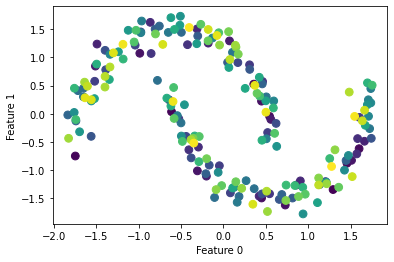

In [93]:
# DBSCAN clustering with eps 0.01 and min_samples = 1
dbscan = DBSCAN(eps = 0.01, min_samples = 1)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [94]:
X, y = make_blobs(random_state=0, n_samples=100)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [95]:
# With low eps 0.01 and minimum sample to form group we can see that each sample form it's own group

Unique groups: [-1  0  1]


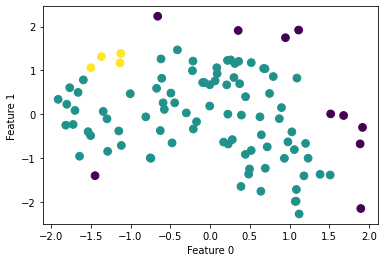

In [96]:
# DBSCAN clustering with default parameters on blob map
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [97]:
# In this example we can see 2 groups and noise.

Unique groups: [-1  0  1]


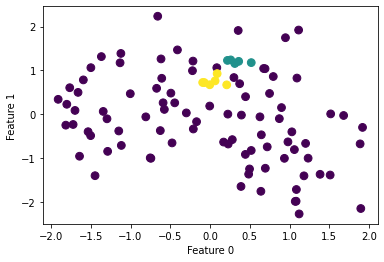

In [98]:
# DBSCAN clustering with eps 0.2
dbscan = DBSCAN(eps = 0.2)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [99]:
# After decresing eps value we have two small groups and a lot of noise areound. Epsilon is to small so the radius distance is not enough to form groups.

Unique groups: [-1  0]


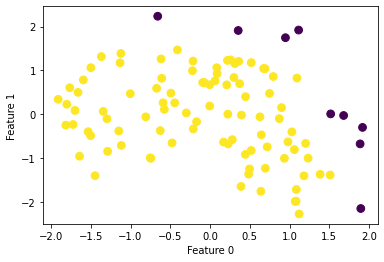

In [100]:
# DBSCAN clustering with eps 0.6
dbscan = DBSCAN(eps = 0.6)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [101]:
# After incresing epsilon, it is possible to see one big group with the noise around.

Unique groups: [0 1 2 3 4 5]


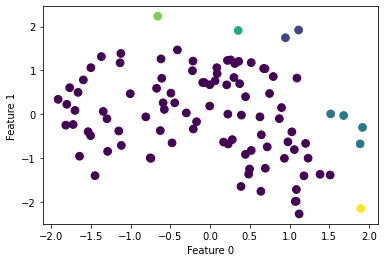

In [102]:
# DBSCAN clustering with eps 0.6 and min_samples = 1
dbscan = DBSCAN(eps = 0.6, min_samples = 1)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plotCluster(clusters, X_scaled)

In [103]:
# Now I decreased number of samples to form group to one. Now we have 5 groups and no noise

**(g)** Try to compare the different clustering methods on the MNIST dataset in the same way
   the book does on the faces dataset on pp. 195-206.

In [104]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_number)
X_pca = pca.transform(X_number)

# apply DBSCAN with default parameters

#dbscan = DBSCAN(min_samples=3, eps=15)
#labels = dbscan.fit_predict(X_pca)
#print("Unique labels: {}".format(np.unique(labels)))

# Count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# The first number in the result corresponds to noise points.
# print("Number of points per cluster: {}".format(np.bincount(labels + 1)))




NameError: name 'X_number' is not defined

## 4. The Local Elections

__You should be able to do this exercise after Lecture 6.__

In the local elections of 2021, around 100 candidates stood for election for the city council of Horsens. 83 of them represented a national party, had more than one candidate and provided answers to the <a href="https://www.dr.dk/nyheder/politik/kandidattest">DR Candidate Test</a>, a test designed to help voters find out who they should vote for. In this test, the candidates answered 18 questions, which we will use as features in the following. The politicians belong to 9 parties, which will be our classes.

The numpy files `X_Horsens.npy` and `Y_Horsens.npy` contains the data. `Y_Horsens.npy` contains a letter representing the party to which each candidate belongs. The following parties are represented:

| Party letter | Party name | Party name (English) | Political position | Party color |
| :-: | :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left | Red |
| B | Radikale Venstre | Social Liberal Party | Centre-left | Indigo |
| C | Det Konservative Folkeparti | Conservative People's Party | Right-wing | Green |
| D | Nye Borgerlige | New Right | Far-right | Black |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing | Fuchsia |
| I | Liberal Alliance | Liberal Alliance | Right-wing | Cyan |
| O | Dansk Folkeparti | Danish People's Party | Far-right | Yellow |
| V | Venstre | Danish Liberal Party | Centre-right | Blue |
| Z* | Enhedslisten | Red-Green Alliance | Far-left | Dark red |

*_Note that, although the party letter of Enhedslisten is actually Ø, we will here use Z to avoid any complications with the wonderful Danish letters Æ, Ø and Å. Feel free to change the Z back to an Ø if you find that it does not cause any problems._

Meanwhile, `X_Horsens.npy` contains the answers to the test as numbers between -1.5 and 1.5, such that -1.5 is "Strongly disagree", -0.5 is "Disagree", 0.5 is "Agree" and 1.5 is "Strongly agree". The 18 questions concern, in order, subdivision, schools, windmills, building permits, tall buildings, housing, child care, culture, nursing homes, taxes, sports, refugees, nursing homes (again), public transportation, meat-free days, welfare, privatization, and religious minorities.

Both files can be imported using `numpy.load`.

__(a)__ How well do you (intuitively) expect that we can predict the partisan affiliation of a candidate based on their answers to the test?

It might be around 50-60%. There will be problem with politicians with from parties ideologically simillar. Also dataset isn't big, with 100 entries and 9 classes there might not be enough of data to learn model well enough. 

__(b)__ Based on the answers from all 83 candidates for the Horsens city council, perform a Principal Component Analysis with 2 principal components. Plot the results in a figure using these 2 components as the axes. Label the points with the party letter and the appropriate color.

In [3]:
X_Horsens = np.load('datasets/4/X_Horsens.npy')
Y_Horsens = np.load('datasets/4/Y_Horsens.npy')
X_train, X_test , y_train, y_test = train_test_split(X_Horsens, Y_Horsens, test_size=0.5, random_state=69)

Xs = StandardScaler().fit_transform(X_Horsens)
pca = decomposition.PCA(n_components=1)
res = pca.fit_transform(Xs)
pca.explained_variance_ratio_

print(pd.DataFrame(pca.components_,columns=list(range(0, 18)),index = ['PC-1']))#,'PC-2'
#pca.components_

            0         1         2         3         4         5         6   \
PC-1  0.150294 -0.041177 -0.225587  0.211652  0.048277 -0.217779  0.256121   

            7         8         9         10        11        12        13  \
PC-1 -0.228058  0.193362  0.318774  0.061752 -0.296982  0.261643 -0.322831   

            14        15        16        17  
PC-1 -0.235702  0.279074  0.315304  0.275889  


[0.43036013 0.10128485]


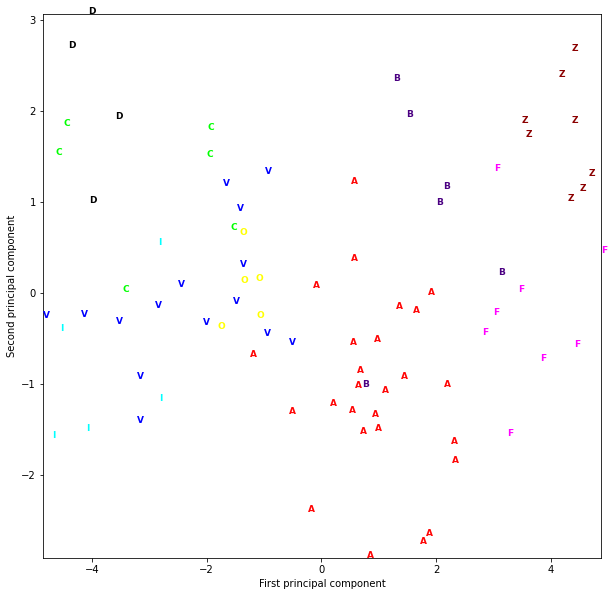

In [4]:
# build a PCA model
pca = decomposition.PCA(n_components=2)
pca.fit(X_Horsens)
# transform the digits data onto the first two principal components
parties_pca = pca.transform(X_Horsens)
colors = { "A":"#FF0707","B":"#4B0082","C":"#00FF00","D":"#000000","F" :"#FF00FF",
          "I":"#00FFFF","O":"#FFFF00","V":"#0000FF", "Z":"#8B0000"}


plt.figure(figsize=(10, 10))
plt.xlim(parties_pca[:, 0].min(), parties_pca[:, 0].max())
plt.ylim(parties_pca[:, 1].min(), parties_pca[:, 1].max())
for i in range(len(X_Horsens)):
    plt.text(parties_pca[i, 0], parties_pca[i, 1], str(Y_Horsens[i]),
             color = colors[Y_Horsens[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
print(pca.explained_variance_ratio_)

__(c)__ Comment on the results. You may consider the following questions for inspiration: Can the political parties be separated? Can the typical distinction of "left-wing" and "right-wing" be discerned? Which of the 18 questions (features) are most important?

[0.43036013 0.10128485]


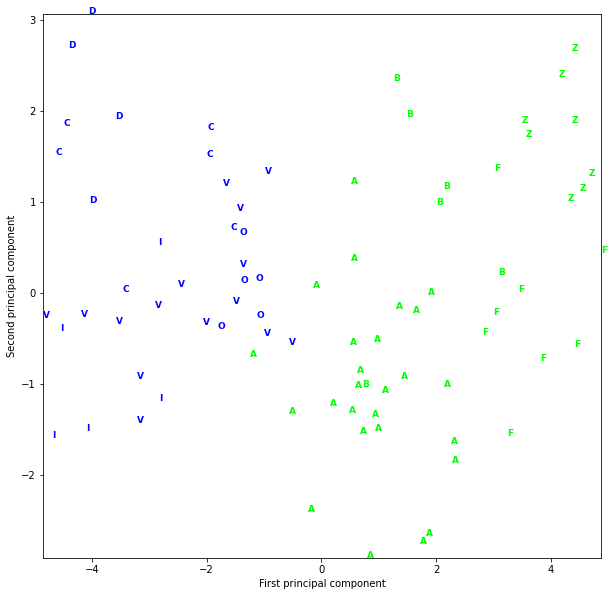

In [5]:
#to answer first two questions we will plot left-wing, right-wing and centrist parties with colours: green, blue, yellow
#only rigth and left
colors = { "A":"#00FF00","B":"#00FF00","C":"#0000FF","D":"#0000FF","F" :"#00FF00","I":"#0000FF","O":"#0000FF","V":"#0000FF", "Z":"#00FF00"}
#right, left and center:
#colors = { "A":"#FFFF00","B":"#FFFF00","C":"#0000FF","D":"#0000FF","F" :"#00FF00", "I":"#0000FF","O":"#0000FF","V":"#FFFF00", "Z":"#00FF00"}

plt.figure(figsize=(10, 10))
plt.xlim(parties_pca[:, 0].min(), parties_pca[:, 0].max())
plt.ylim(parties_pca[:, 1].min(), parties_pca[:, 1].max())
for i in range(len(X_Horsens)):
    plt.text(parties_pca[i, 0], parties_pca[i, 1], str(Y_Horsens[i]),
             color = colors[Y_Horsens[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
print(pca.explained_variance_ratio_)

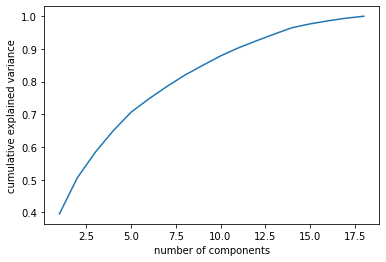

In [47]:
x = list(range(1, 1 + len(pca.explained_variance_ratio_)))
plt.plot(x, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


The number of candidates (83) is on the (very) low side when we want to do machine learning. Luckily, the neighbouring city of Databorg had no less than 8,300 candidates standing for election, with a political environment similar to that of Horsens. In the following, we will use the data from Databorg. These are stored in the numpy files `X_Databorg.npy` and `Y_Databorg.npy` in same format as the Horsens data.

__(d)__ Once again, perform a Principal Component Analysis and visualize the results. Compare the results to those of the Horsens data.

In [23]:
X_Databorg = np.load('datasets/4/X_Databorg.npy')
Y_Databorg = np.load('datasets/4/Y_Databorg.npy')

Xs = StandardScaler().fit_transform(X_Databorg)
pca = decomposition.PCA(n_components=1)
res = pca.fit_transform(Xs)
pca.explained_variance_ratio_

print(pd.DataFrame(pca.components_,columns=list(range(0, 18)),index = ['PC-1']))#,'PC-2'
#pca.components_


            0         1         2        3         4         5         6   \
PC-1 -0.135371  0.032907  0.219779 -0.19987 -0.035773  0.220459 -0.258953   

            7         8         9         10       11        12       13  \
PC-1  0.198724 -0.187066 -0.345148 -0.056947  0.29343 -0.263243  0.31861   

            14       15        16        17  
PC-1  0.239424 -0.28733 -0.327374 -0.273094  


[0.24041612 0.07870168]


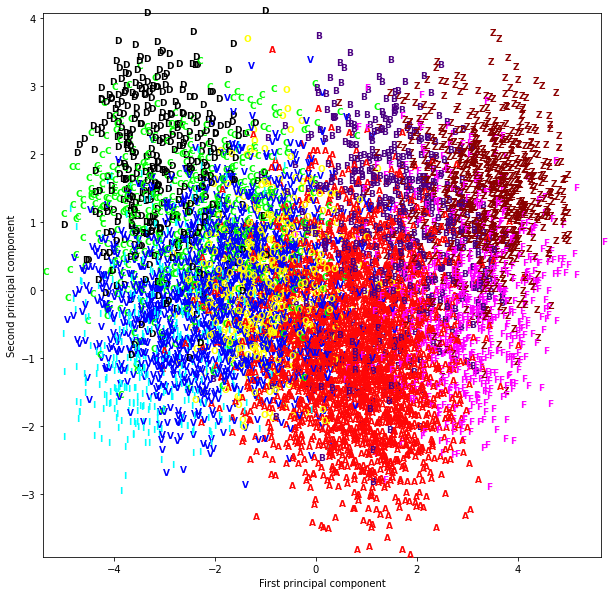

In [106]:
# build a PCA model
pca = decomposition.PCA(n_components=2)
pca.fit(X_Databorg)
# transform the digits data onto the first two principal components
parties_pca = pca.transform(X_Databorg)
colors = { "A":"#FF0707","B":"#4B0082","C":"#00FF00","D":"#000000","F" :"#FF00FF",
          "I":"#00FFFF","O":"#FFFF00","V":"#0000FF", "Z":"#8B0000"}


plt.figure(figsize=(10, 10))
plt.xlim(parties_pca[:, 0].min(), parties_pca[:, 0].max())
plt.ylim(parties_pca[:, 1].min(), parties_pca[:, 1].max())
for i in range(len(X_Databorg)):
    plt.text(parties_pca[i, 0], parties_pca[i, 1], str(Y_Databorg[i]),
             color = colors[Y_Databorg[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
print(pca.explained_variance_ratio_)

In [15]:
#to answer first two questions we will plot left-wing, right-wing and centrist parties with colours: green, blue, yellow
#only rigth and left
#colors = { "A":"#00FF00","B":"#00FF00","C":"#0000FF","D":"#0000FF","F" :"#00FF00","I":"#0000FF","O":"#0000FF","V":"#0000FF", "Z":"#00FF00"}
#right, left and center:
colors = { "A":"#FFFF00","B":"#FFFF00","C":"#0000FF","D":"#0000FF","F" :"#00FF00", "I":"#0000FF","O":"#0000FF","V":"#FFFF00", "Z":"#00FF00"}

plt.figure(figsize=(10, 10))
plt.xlim(parties_pca[:, 0].min(), parties_pca[:, 0].max())
plt.ylim(parties_pca[:, 1].min(), parties_pca[:, 1].max())
for i in range(len(X_Databorg)):
    plt.text(parties_pca[i, 0], parties_pca[i, 1], str(Y_Databorg[i]),
             color = colors[Y_Databorg[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
print(pca.explained_variance_ratio_)

NameError: name 'parties_pca' is not defined

<Figure size 720x720 with 0 Axes>

Confident that we can predict the partisan affiliation of a politician reasonably well based on their answers to the test, we want to build a model that will allow us to distinguish between the 9 political parties. For this purpose, we split the data into a training and a validation set.

__(e)__ Split the data into a training and a validation set, with appropriate fractions.

In [6]:
X_train, X_test , y_train, y_test = train_test_split(X_Databorg, Y_Databorg,  random_state=69)#stratify?

First, we assume that a Naive Bayes approach is sufficient for our purposes.

__(f)__ Comment on the basic assumption of the Naive Bayes approach. Is this a reasonable assumption for the problem at hand?

Naive Byens assumes that given predictors are unrelated. So in this case it assumes that answer to question nr 1 is unrelated to answer to question nr 2 or any other. As it's not entirely true, for example welfare questions will be related, if one is answered negatively then it's highly probable that other one will be rated so as well. In our case we can try ignoring it, to check what results will it show

__(g)__ Classify the instances of the validation set using a Naive Bayes approach. Comment on the results.

In [113]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print("Accuracy score train: {}".format(nb.score(X_train, y_train)))
print("Accuracy score test: {}".format(nb.score(X_test, y_test)))

Accuracy score: 0.7214457831325302
Accuracy score: 0.7060240963855422


Assume instead that a _k_-nearest neighbour approach is sufficient for our  needs.

__(h)__ Using default settings of the _k_-NN classifier, classify the instances of the validation set. Comment on the performance.

In [114]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("Model accuracy on the test data: {}".format(knn.score(X_test,y_test)))
print("Model accuracy on the train data: {}".format(knn.score(X_train,y_train)))

Model accuracy on the original/test? data: 0.8043373493975904
Model accuracy on the train data: 0.8612048192771085


# Accuracy increased while using k-NN classifier, that means that... 

__(i)__ Play around with different values of _k_. Decide on a "good" value of _k_. Comment on the results.

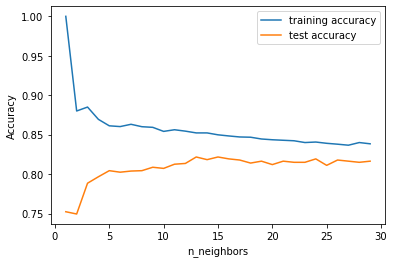

In [115]:
training_accuracy = []
test_accuracy = []

ks = range(1, 30)

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(ks, training_accuracy, label="training accuracy")
plt.plot(ks, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend();

####  Looks like 15 neithbours would be optimal number in this case to avoid overfitting and get reasonable accuracy 


We now try to use a decision tree instead.

__(j)__ What is the _minimum_ depth of an appropriate decision tree? Why?

In [18]:
#????? there is formula that to obtain minimum depth you should try deviding samples by two everytime 
#but i don't really get how it's possible, but its log2(n)+1, 13?
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_train.shape

(6225,)

__(k)__ Build a decision tree with at least the depth from above. Play around with the tree depth. Include a figure that shows some relevant measure of the performance as a function of the tree depth. Comment on any issues of over-fitting. Decide on a tree which you will keep for later use. Can you do better than the _k_-NN classifier?

In [19]:
print("Accuracy on training data: {}".format(clf.score(X_train, y_train)))
print("Accuracy on testing data: {}".format(clf.score(X_test, y_test)))
#it's overfitting with default settings


Accuracy on training data: 1.0
Accuracy on testing data: 0.6448192771084338


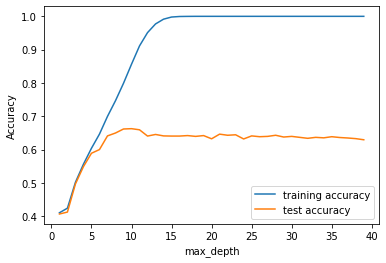

In [21]:
training_accuracy = []
test_accuracy = []

ds = range(1, 40)

for d in ds:
    clf = DecisionTreeClassifier(max_depth = d)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(ds, training_accuracy, label="training accuracy")
plt.plot(ds, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("max_depth")
plt.legend();
#still overfitting 


__(l)__ What are the most important features? Visualize this in an appropriate way. Does it match what you would expect? Compare to the results of the PCA analysis. Do we expect them to be the same? Why/why not?

Feature importances:
[0.042412   0.05008284 0.04216465 0.06781494 0.09130147 0.05868361
 0.04602228 0.03286569 0.03989783 0.13130863 0.06071392 0.05419627
 0.03212036 0.03590479 0.03462394 0.05148774 0.08922573 0.03917329]


AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

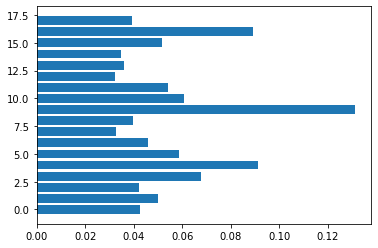

In [25]:
tree = DecisionTreeClassifier(max_depth = 10, random_state = 69)
tree.fit(X_train, y_train)
print("Feature importances:\n{}".format(tree.feature_importances_))
def plot_feature_importances_cancer(model):
    n_features = X_Databorg.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_Databorg.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_cancer(tree)

We know that decision trees suffer from certain problems that may be solved by using decision forests.

__(m)__ Build a decision forest. Play around with the number of trees in the forest. Decide on a forest.

__(n)__ Extract the most important features. Comment and compare with previously obtained results.

Finally, we want to compare the models we have worked with so far (i.e., Naive Bayes, _k_-NN, decision tree and decision forest).

__(o)__ Compare the results of the in terms of confusion matrices, accuracy, precision, recall, and f-score. How well can we predict the partisan affiliation of a candidate based on their answers to a test? How does this compare with your intuition? 

## 5. Sentiment Analysis

__You should be able to do this exercise after Lecture 8.__

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

reviews = pd.read_csv('datasets/5/reviews.txt', header=None)
labels = pd.read_csv('datasets/5/labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

#removing reviews that are not strings

print(reviews.shape)

#reviews = reviews[~reviews[0].str.isnumeric()]
reviews = reviews.rename(columns={0 : "text"})
print(reviews.head())
#reviews.columns

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...
(25000, 1)
                                                text
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.

In [4]:
X_trainval, X_test, y_trainval, y_test = train_test_split(reviews, Y, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=69)
print("Size of training set:{}".format(X_train.shape[0]))
print("Size of validation set:{}".format(X_val.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training set:14062
Size of validation set:4688
Size of test set:6250


**(b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [5]:
vect = CountVectorizer(max_features = 10000)
vect.fit(X_train['text'])

X_train = vect.transform(X_train['text'])
X_test = vect.transform(X_test['text'])
X_val = vect.transform(X_val['text'])

X_train = pd.DataFrame(X_train.toarray(),columns = vect.get_feature_names())
X_val = pd.DataFrame(X_val.toarray(),columns = vect.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(),columns = vect.get_feature_names())

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**(c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [175]:
print(X_train.head())
print(X_test.head())
print(X_val.head())

   aaron  abandon  abandoned  abbott  abby  abc  abducted  abigail  abilities  \
0      0        0          0       0     0    0         0        0          0   
1      0        0          0       0     0    0         0        0          0   
2      0        0          0       0     0    0         0        0          0   
3      0        0          0       0     0    0         0        0          0   
4      0        0          0       0     0    0         0        0          0   

   ability  ...  zizek  zodiac  zombi  zombie  zombies  zone  zoo  zoom  \
0        0  ...      0       0      0       0        0     0    0     0   
1        0  ...      0       0      0       0        0     0    0     0   
2        0  ...      0       0      0       0        0     0    0     0   
3        0  ...      0       0      0       0        0     0    0     0   
4        0  ...      0       0      0       0        0     0    0     0   

   zorro  zu  
0      0   0  
1      0   0  
2      0   0  
3 

Single word is a feature that is if present in review has value 1 and if not then 0. Number of words was limited to 10000 most common words present in training set. Therefore one review has 10000 features now.  

**(d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [18]:
X_train.shape[1]

10000

In [72]:
model = Sequential() #initialize a neural network model

input_dim = X_train.shape[1]
input_size = X_train.shape[0]

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

model.add(Dense(10, activation='relu', input_dim=input_dim)) #hidden layer #kernel_regularizer = regularizers.l2(0.001)

#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) #output layer

#sgd = optimizers.SGD(learning_rate = 0.1)

model.compile(loss='binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, epochs = 2, batch_size = 50, verbose = 0,validation_data=(X_val, y_val))#, validation_split = 0.2)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 10)                100010    
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 100,021
Trainable params: 100,021
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

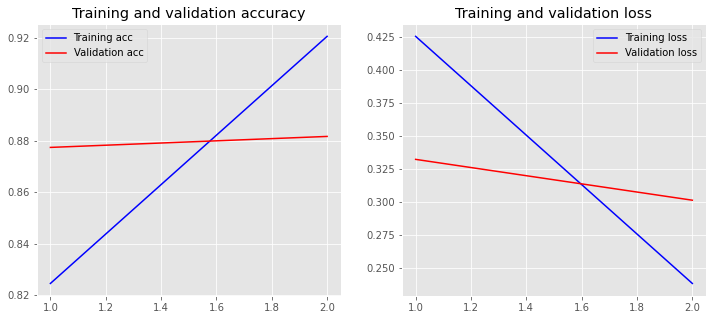

In [74]:
plot_history(history)

**(e)** Test your sentiment-classifier on the test set.

In [73]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Loss + accuracy on train data: {}".format(model.evaluate(X_train, y_train)))
print("Loss + accuracy on test data: {}".format(model.evaluate(X_test, y_test)))

440/440 [==============================] - 2s 5ms/step - loss: 0.1705 - accuracy: 0.9538
Loss + accuracy on train data: [0.17047946155071259, 0.9538472294807434]
196/196 [==============================] - 1s 4ms/step - loss: 0.2830 - accuracy: 0.8971
Loss + accuracy on test data: [0.28302881121635437, 0.8971199989318848]


**(h)** Use the classifier to classify a few sentences you write yourselves. 

In [37]:
sentences = ["teribble movie, I loved it","Excellent movie, I hated it!","Awful movie, I regret I saw it","I will watch it again and again"]
#sentences = pd.DataFrame(sentences,columns = vect.get_feature_names())
sentences = vect.transform(sentences)

model.predict(sentences) 


1/1 [==============================] - 0s 15ms/step


array([[9.8564458e-01],
       [9.9498433e-01],
       [9.2910595e-06],
       [9.7786427e-01]], dtype=float32)

## 6. Speech Recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

__(a)__ Explore and prepare the data, including splitting the data in training, validation and testing data, handling outliers, perhaps taking logarithms, etc. Data preparation is - as always - quite important. Document what you do.

__(b)__ Visualize a few examples of yes's, no's, stop's and go's, so that you have a reasonable intuitive understanding of the difference between the words.

__(c)__ Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?

__(d)__ Classify instances of the validation set using your models. Comment on the results in terms of metrics you have learned in the course.

__(e)__ Identify (a few) misclassified words, including what they are misclassified as. Visualize them as before, and compare with your intuitive understanding of how the words look. Do you find the misclassified examples surprising?

## 7. Group Assignment & Presentation



__You should be able to start up on this exercise after Lecture 1.__

*This exercise must be a group effort. That means everyone must participate in the assignment.*

In this assignment you will solve a data science problem end-to-end, pretending to be recently hired data scientists in a company. To help you get started, we've prepared a checklist to guide you through the project. Here are the main steps that you will go through:

1. Frame the problem and look at the big picture
2. Get the data
3. Explore and visualise the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models
7. Present your solution 

In each step we list a set of questions that one should have in mind when undertaking a data science project. The list is not meant to be exhaustive, but does contain a selection of the most important questions to ask. We will be available to provide assistance with each of the steps, and will allocate some part of each lesson towards working on the projects.

Your group must submit a _**single**_ Jupyter notebook, structured in terms of the first 6 sections listed above (the seventh will be a video uploaded to some streaming platform, e.g. YouTube, Vimeo, etc.).

### 1. Analysis: Frame the problem and look at the big picture
1. Find a problem/task that everyone in the group finds interesting
2. Define the objective in business terms
3. How should you frame the problem (supervised/unsupervised etc.)?
4. How should performance be measured?

### 2. Get the data
1. Find and document where you can get the data from
2. Get the data
3. Check the size and type of data (time series, geographical etc)

### 3. Explore the data
1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 4. Prepare the data
Notes:
* Work on copies of the data (keep the original dataset intact).
* Write functions for all data transformations you apply, for three reasons:
    * So you can easily prepare the data the next time you run your code
    * So you can apply these transformations in future projects
    * To clean and prepare the test set
    
    
1. Data cleaning:
    * Fix or remove outliers (or keep them)
    * Fill in missing values (e.g. with zero, mean, median, regression ...) or drop their rows (or columns)
2. Feature selection (optional):
    * Drop the features that provide no useful information for the task (e.g. a customer ID is usually useless for modelling).
3. Feature engineering, where appropriate:
    * Discretize continuous features
    * Use one-hot encoding if/when relevant
    * Add promising transformations of features (e.g. $\log(x)$, $\sqrt{x}$, $x^2$, etc)
    * Aggregate features into promising new features
4. Feature scaling: standardise or normalise features

### 5. Short-list promising models
We expect you to do some additional research and train at **least one model per team member**.

1. Train mainly quick and dirty models from different categories (e.g. linear, SVM, Random Forests etc) using default parameters
2. Measure and compare their performance
3. Analyse the most significant variables for each algorithm
4. Analyse the types of errors the models make
5. Have a quick round of feature selection and engineering if necessary
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

### 6. Fine-tune the system
1. Fine-tune the hyperparameters
2. Once you are confident about your final model, measure its performance on the test set to estimate the generalisation error

### 7. Present your solution
1. Document what you have done
2. Create a nice 15 minute video presentation with slides
    * Make sure you highlight the big picture first
3. Explain why your solution achieves the business objective
4. Don't forget to present interesting points you noticed along the way:
    * Describe what worked and what did not
    * List your assumptions and you model's limitations
5. Ensure your key findings are communicated through nice visualisations or easy-to-remember statements (e.g. "the median income is the number-one predictor of housing prices")
6. Upload the presentation to some online platform, e.g. YouTube or Vimeo, and supply a link to the video in the notebook.

## References

Géron, A. 2017, *Hands-On Machine Learning with Scikit-Learn and Tensorflow*, Appendix B, O'Reilly Media, Inc., Sebastopol.
Wunderground.com. 2022. The Highest Anemometer-Measured Wind Speeds on Earth. Available at: <https://www.wunderground.com/cat6/the-highest-anemometer-measured-wind-speeds-on-earth#:~:text=253%20mph%20%E2%80%A2%20Barrow%20Island%2C%20Australia%20%E2%80%A2%20April%2010%2C%201996&text=Wind%20trace%20taken%20at%20Barrow,6%3A15%20pm%20local%20time.> [Accessed 11 October 2022].